# Gaussian Process 

### Data Training

In [1]:
import sys
import os
import matplotlib.pyplot as plt

# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import numpy as np
from elliptic_files.train_elliptic import samples_param
from elliptic_files.FEM_Solver import FEMSolver,Parametric_K

import jax.numpy as jnp
from jax.scipy.linalg import solve_triangular
from scipy.optimize import minimize
import jax
import time


/home/s2113174/anaconda3/envs/fenicsx-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

jax.config.update("jax_enable_x64", True)
class KernelFunction:
    def __init__(self,kernel_type="squared_exponential"):

        # Supported kernels
        supported_covariances = {
            "squared_exponential": self.squared_exponential_cov,
            "grad_squared_exponential": self.grad_squared_exponential_cov
        }

        if kernel_type in supported_covariances:
            self.covariance = supported_covariances[kernel_type]
        else:
            raise ValueError(f"Kernel type '{kernel_type}' is not supported.")
        
    def euclidean_distance_matrix(self,x, y):
        x_sq = jnp.sum(x ** 2, axis=1, keepdims=True)
        y_sq = jnp.sum(y ** 2, axis=1, keepdims=True).T
        xy = jnp.dot(x, y.T)
        dist_sq = x_sq - 2 * xy + y_sq
        return jnp.sqrt(jnp.maximum(dist_sq, 0.0))

    def squared_exponential_cov(self,r, sigma, l):
        return (sigma**2) * jnp.exp(-0.5 * (r/l) ** 2)

    def grad_squared_exponential_cov(self, r, sigma, l):
        return ((sigma/l)**2) *r * jnp.exp(-0.5 * (r/l) ** 2)
    
    def compute_covariance(self,X,params,Y = None):
        Y = X if Y is None else Y
        d = self.euclidean_distance_matrix(X, Y)
        return self.covariance(d,*params)

class GaussianProcess:
    def __init__(self,X_train,Y_train, x_spc = None,  prior_mean =0, kernel = "squared_exponential"):

        self.X_train = jnp.array(X_train, dtype=jnp.float64)
        self.Y_train = jnp.array(Y_train, dtype=jnp.float64).reshape(-1)
        self.spatial_obs = Y_train.shape[-1]
        self.param_obs = X_train.shape[0]
        self.dim_total = self.spatial_obs*self.param_obs

        self.prior_mean = prior_mean
        self.kernel = KernelFunction(kernel_type=kernel)
        self.opt_params = None  # Store optimized parameters
        self.x_spc = x_spc

    def observed_kernel(self,params, params_spc = None):
        # Step 1: Compute covariance matrix
        spatial_obs_cov = jnp.eye(self.spatial_obs, dtype=jnp.float64) if self.x_spc is None else self.kernel.compute_covariance(self.x_spc,[1,params_spc])
        cov_matrix_ob = self.kernel.compute_covariance(self.X_train,params)
        cov_matrix = jnp.kron(cov_matrix_ob, spatial_obs_cov) +  1e-10 * jnp.eye(self.dim_total , dtype=jnp.float64)
        # Step 2: Cholesky decomposition
        L = jnp.linalg.cholesky(cov_matrix)
        idt = jnp.eye(L.shape[0])
        # Step 3: Solve the triangular system directly
        z = solve_triangular(L, idt, lower=True)
        z_t = solve_triangular(L, idt, lower=True, trans=1)
        return L, jnp.dot(z_t, z)

    def neg_log_likelihood(self, full_params):
        if self.x_spc is not None:
            params_spc = full_params[-1]
            params = full_params[:-1]
        else:
            params = full_params
            params_spc = None
        
        L, cov_inv = self.observed_kernel(params,params_spc)

        # Compute log determinant of K via Cholesky: logdet(K) = 2 * sum(log(diag(L)))
        logdet_K = 2.0 * jnp.sum(jnp.log(jnp.diag(L)))

        return 0.5 * (logdet_K + jnp.dot( self.Y_train.T,jnp.dot(cov_inv, self.Y_train)) + self.dim_total * jnp.log(2 * jnp.pi))

    def nll_grad(self, params):
        """Compute the gradient of the negative log-likelihood"""
        return jax.grad(self.neg_log_likelihood)(params)
    
    def optimize_nll(self,init_params):
        res = minimize(self.neg_log_likelihood,init_params,
                        method="L-BFGS-B",jac=self.nll_grad,bounds=[(1e-5, None)] * len(init_params))
        self.opt_params = res.x  # Store optimized params

        if self.x_spc is not None:
            self.opt_params = res.x[:-1]
            self.opt_params_spc = res.x[-1]
            _, self.obs_cov_inv = self.observed_kernel(self.opt_params, self.opt_params_spc)
            self.spatial_obs_cov = self.kernel.compute_covariance(self.x_spc,[1,self.opt_params_spc])
        else:
            self.opt_params = res.x
            _, self.obs_cov_inv = self.observed_kernel(self.opt_params, None)
            self.spatial_obs_cov = jnp.eye(self.spatial_obs, dtype=jnp.float64)

        self.inv_dif = self.obs_cov_inv @ (self.Y_train - self.prior_mean)
            

    def predict_mean(self, x_test):
        cov_train_test_ind = self.kernel.compute_covariance(x_test,self.opt_params,Y = self.X_train)
        cov_train_test = jnp.kron(cov_train_test_ind, self.spatial_obs_cov)  
        return self.prior_mean + cov_train_test @ self.inv_dif
    
    
    def predict_var(self, x_test):
        cov_test_train_ind = self.kernel.compute_covariance(x_test, self.opt_params, Y=self.X_train)
        cov_test_train = np.kron(cov_test_train_ind, self.spatial_obs_cov)

        #cov_train_test_ind = self.kernel.compute_covariance(self.X_train, self.opt_params, Y=x_test)
        cov_test_ind = self.kernel.compute_covariance(x_test, self.opt_params)
        cov_test = np.kron(cov_test_ind, self.spatial_obs_cov)

        pred_var = cov_test - cov_test_train @ (self.obs_cov_inv @ cov_test_train.T)

        return pred_var


In [3]:
from elliptic_files.FEM_Solver import RootFinder
jax.config.update("jax_enable_x64", True)

class EllipticPIGP:
    def __init__(self,data_training,reg_matrix = 1e-6,lam = 1 /4,kernel = "squared_exponential", 
                 l_sigma_parameters=(1,1),l_sigma_spatial=(1,1)):
        # Training data
        self.parameters_data = data_training["parameters_data"]
        self.solutions_data = data_training["solutions_data"]
        self.x_sol_data = data_training["x_solutions_data"]

        self.x_bc = data_training["x_bc"]
        self.y_bc = data_training["y_bc"]

        self.source_func_x = data_training["source_func_x"].reshape(-1,1)
        self.source_func_f_x = data_training["source_func_f_x"]

        self.n_parameter_obs = self.parameters_data.shape[0]
        self.parameter_dim = self.parameters_data.shape[-1]

        # Roots for KL
        self.finder = RootFinder(lam, self.parameter_dim)
        self.roots = jnp.array(self.finder.find_roots())

        # Kernels
        self.kernel_parameter = KernelFunction(kernel_type=kernel)
        self.kernel_spatial = KernelFunction(kernel_type=kernel)
        self.sigma_l_parameters = l_sigma_parameters
        self.sigma_l_spatial = l_sigma_spatial
        self.reg_matrix = reg_matrix

        #Informed Kernel
        self.cov_matrix = self.informed_kernel(self.parameters_data,self.parameters_data,self.sigma_l_spatial,self.sigma_l_parameters)
        self.g_trained = self.g_training()

        #Inverse
        #self.L, self.inverse_kernel, self.invk_g = self.kernel_inverse(self.cov_matrix)
        self.invk_g = self.kernel_inverse(self.cov_matrix,self.g_training())

    def spatial_kernel(self,x1,x2, parameters):
        return self.kernel_spatial.compute_covariance(x1.reshape(-1,1), params=parameters,Y = x2)
    
    def parameter_kernel(self,theta1,theta2,parameters):
        return self.kernel_parameter.compute_covariance(theta1, params=parameters,Y = theta2)

    @property
    def A(self):
        """Compute the A coefficients."""
        return jnp.sqrt(1 / ((1/8)*(5 + (self.roots / 2)**2) + 
                            (jnp.sin(2*self.roots) / (4*self.roots)) * ((self.roots / 4)**2 - 1) - (jnp.cos(2*self.roots)/8)))
    @property
    def an(self):
        """Compute the an values."""
        return jnp.sqrt(8 / (self.roots**2 + 16))
    
    def exp_kl_eval(self,theta, x):
        """
        Eval exp(kl)
        """
        # basis
        basis =self.A[:,None]*self.an[:,None]*(jnp.sin(self.roots[:, None] * x) + \
                                               (self.roots[:, None] / 4) * jnp.cos(self.roots[:, None] * x))
        # Final result: shape (n, m) = (n, r) @ (r, m)
        result = theta @ basis

        return jnp.exp(result)
    
    def grad_kl_eval(self,theta, x):
        """
        kl'
        """
        # basis
        basis =self.A[:,None]*self.an[:,None]*self.roots[:, None]*(jnp.cos(self.roots[:, None] * x) - \
                                               (self.roots[:, None] / 4) * jnp.sin(self.roots[:, None] * x))
        # Final result: shape (n, m) = (n, r) @ (r, m)
        result = theta @ basis

        return result
    

    def kernel_uf(self,theta,x,parameters):
        _,l_spatial = parameters
        cov = self.spatial_kernel(x,self.source_func_x,parameters)
        exp_kl = self.exp_kl_eval(theta,self.source_func_x.reshape(1,-1)).reshape(1,-1)
        grad_kl = self.grad_kl_eval(theta,self.source_func_x.reshape(1,-1)).reshape(1,-1)

        delta_x = (x.reshape(1,-1) - self.source_func_x).T
        
        pi_gp = ( (- grad_kl * delta_x + 1) / l_spatial**2 -  delta_x**2  / l_spatial**4 )* exp_kl
        return pi_gp*cov

    def kernel_ff(self,theta1,theta2,parameters):
        _,l_spatial = parameters
        cov = self.spatial_kernel(self.source_func_x,self.source_func_x,parameters)

        exp_kl1 = self.exp_kl_eval(theta1,self.source_func_x.reshape(1,-1)).reshape(-1,1)
        grad_kl1 = self.grad_kl_eval(theta1,self.source_func_x.reshape(1,-1)).reshape(-1,1)
        exp_kl2 = self.exp_kl_eval(theta2,self.source_func_x.reshape(1,-1)).reshape(-1,1)
        grad_kl2 = self.grad_kl_eval(theta2,self.source_func_x.reshape(1,-1)).reshape(-1,1)

        delta_x = ((self.source_func_x.reshape(1,-1) - self.source_func_x).T) / l_spatial**2

        a1 = grad_kl2.T - grad_kl1
        a2 = 6 /l_spatial**2 + grad_kl2.T*grad_kl1
        a3 = 3*(grad_kl1 - grad_kl2.T)/ l_spatial**2
        a4 = grad_kl2.T*grad_kl1 / l_spatial**2 + 3/l_spatial**4
        llk = (delta_x**4 + a1*delta_x**3 - a2*delta_x**2 + a3*delta_x + a4)*exp_kl1*exp_kl2.T
        return llk*cov
    
    def informed_kernel(self,theta1,theta2,spatial_hyperpara,parameters_hyperpara):
        kernel_parameter = self.parameter_kernel(theta1,theta2,parameters_hyperpara)

        kuu = self.spatial_kernel(self.x_sol_data,self.x_sol_data,spatial_hyperpara)
        Kuu = jnp.kron(kernel_parameter,kuu)

        kug = self.spatial_kernel(self.x_sol_data,self.x_bc,spatial_hyperpara)
        Kug = jnp.kron(kernel_parameter,kug)
        
        Kuf = self.block_matrix_builder(theta1,theta2,self.x_sol_data,spatial_hyperpara,parameters_hyperpara,block_type="uf")

        kgg = self.spatial_kernel(self.x_bc,self.x_bc,spatial_hyperpara)
        Kgg = jnp.kron(kernel_parameter,kgg)

        Kgf = self.block_matrix_builder(theta1,theta2,self.x_bc,spatial_hyperpara,parameters_hyperpara,block_type="uf")

        Kff = self.block_matrix_builder(theta1,theta2,self.x_bc,spatial_hyperpara,parameters_hyperpara,block_type="ff")

        # Concatenate horizontally: [A | B], [C | D]
        top = jnp.concatenate([Kuu, Kug,Kuf], axis=1)
        middle = jnp.concatenate([Kug.T, Kgg,Kgf], axis=1)
        bottom = jnp.concatenate([Kuf.T, Kgf.T,Kff], axis=1)

        # Concatenate vertically
        cov = jnp.concatenate([top, middle,bottom], axis=0)
        return cov + (self.reg_matrix)*jnp.eye(cov.shape[0], dtype=jnp.float64)
    
    def block_matrix_builder(self,th1,th2, x,spatial_hyperpara,parameters_hyperpara,block_type="uf"):
        nth1,nth2 = th1.shape[0],th2.shape[0]

        def compute_block(i, j):
            theta1 = th1[i,:]
            theta2 = th2[j,:]
            cov_scalar = self.parameter_kernel(theta1.reshape(-1,self.parameter_dim),theta2.reshape(-1,self.parameter_dim),parameters_hyperpara)
            if block_type == "uf":
                pde_matrix = self.kernel_uf(theta2,x,spatial_hyperpara)  # shape: (sdim, sdim)
            elif block_type == "ff":
                pde_matrix = self.kernel_ff(theta1,theta2,spatial_hyperpara)  # shape: (sdim, sdim)
            return cov_scalar * pde_matrix  # elementwise scalar * matrix

        # Vectorize across i and j
        def build_matrix():
            return jnp.block([[compute_block(i, j) for j in range(nth2)] for i in range(nth1)])

        block_matrix = build_matrix()  # shape: (sdim * n_params, sdim * n_params)

        return block_matrix
    
    def g_training(self):
        y_bc_n = jnp.tile(self.y_bc.reshape(-1),self.n_parameter_obs).reshape(-1,1)
        f_source_n = jnp.tile(self.source_func_f_x.reshape(-1),self.n_parameter_obs).reshape(-1,1)
        return jnp.concat([self.solutions_data.reshape(-1,1),y_bc_n,f_source_n])
        
    # def kernel_inverse(self,cov_matrix):        
    #     # Step 1: Cholesky decomposition
    #     L = jnp.linalg.cholesky(cov_matrix)
    #     idt = jnp.eye(L.shape[0])
    #     # Step 2: Solve the triangular system directly
    #     z = solve_triangular(L, idt, lower=True)
    #     z_t = solve_triangular(L, idt, lower=True, trans=1)

    #     g = self.g_training()
    #     k_inv = jnp.dot(z_t, z)
    #     _kg = k_inv@g
    #     return L, k_inv, _kg

    def kernel_inverse(self,cov_matrix, Y):
        return jnp.linalg.solve(cov_matrix,Y)
    
    def neg_log_likelihood(self, full_params):
        l_sigma_spatial, l_sigma_parameters = jnp.split(full_params,2)

        #print(l_sigma_spatial, l_sigma_parameters)
        # Rebuild the covariance matrix
        cov_matrix = self.informed_kernel(self.parameters_data,self.parameters_data,l_sigma_spatial, l_sigma_parameters)

        # Recompute inverse and Cholesky
        #L, inverse_kernel, _kg = self.kernel_inverse(cov_matrix)
        kinv_y = self.kernel_inverse(cov_matrix,self.g_trained)
        L = jnp.linalg.cholesky(cov_matrix)

        # Compute NLL
        logdet_K = 2.0 * jnp.sum(jnp.log(jnp.diag(L)))
        dim_total = L.shape[0]

        nll = -0.5 * (logdet_K + jnp.dot( self.g_trained.T,kinv_y) + dim_total * jnp.log(2 * jnp.pi))
        return nll.squeeze()

    def nll_grad(self, params):
        """Compute the gradient of the negative log-likelihood"""
        return jax.grad(self.neg_log_likelihood)(params)
    
    def optimize_nll(self,init_params):
        res = minimize(self.neg_log_likelihood,init_params,
                        method="L-BFGS-B",bounds=[(1e-5, 100)] * len(init_params))
        # Save the optimized parameters
        print(f"Optimized parameters: {res.x}")
        self.sigma_l_parameters, self.sigma_l_spatial = jnp.split(res.x,2)
        
         #Updating Informed Kernel
        self.cov_matrix = self.informed_kernel(self.parameters_data,self.parameters_data,self.sigma_l_spatial,self.sigma_l_parameters)

        #Updating Inverse
        #self.L, self.inverse_kernel, self.invk_g = self.kernel_inverse(self.cov_matrix,self.g_trained)
        self.invk_g = self.kernel_inverse(self.cov_matrix,self.g_trained)

    def marginal_val(self, theta_test,x_test = None):
        if x_test is None:
            x_test = self.x_sol_data

        kernel_parameter = self.parameter_kernel(theta_test,self.parameters_data,self.sigma_l_parameters)

        kuu = self.spatial_kernel(x_test,self.x_sol_data, self.sigma_l_spatial)
        Kuu = jnp.kron(kernel_parameter,kuu)

        kug = self.spatial_kernel(x_test,self.x_bc, self.sigma_l_spatial)
        Kug = jnp.kron(kernel_parameter,kug)
        
        Kuf = self.block_matrix_builder(theta_test,self.parameters_data,x_test,self.sigma_l_spatial,self.sigma_l_parameters,block_type="uf")

        return jnp.concatenate([Kuu, Kug,Kuf], axis=1)


    def prediction(self, theta_test,x_test = None, var=True):
        if x_test is None:
            x_test = self.x_sol_data

        matrix_test = self.marginal_val(theta_test,x_test)
        marginal_mean = matrix_test @ self.invk_g

        if var:
            kernel_spatial = self.spatial_kernel(x_test,x_test, self.sigma_l_spatial)
            kernel_param = self.parameter_kernel(theta_test,theta_test,self.sigma_l_parameters)
            kinv_y = self. kernel_inverse(self.cov_matrix, matrix_test.T)

            #cov = jnp.kron(kernel_param,kernel_spatial) - matrix_test @ self.inverse_kernel @ matrix_test.T
            cov =  jnp.kron(kernel_param,kernel_spatial) - matrix_test @ kinv_y
            return marginal_mean, cov
        return marginal_mean

In [4]:
import torch
import numpy as np
from scipy.optimize import minimize
from elliptic_files.FEM_Solver import RootFinder
import math
import torch

class KernelFunctionb:
    def __init__(self, kernel_type="squared_exponential"):
        # Supported kernels
        supported_covariances = {
            "squared_exponential": self.squared_exponential_cov,
            "grad_squared_exponential": self.grad_squared_exponential_cov,
            "matern_52": self.matern52_kernel
        }

        if kernel_type in supported_covariances:
            self.covariance = supported_covariances[kernel_type]
        else:
            raise ValueError(f"Kernel type '{kernel_type}' is not supported.")

    def euclidean_distance_matrix(self, x, y):
        x_sq = torch.sum(x ** 2, dim=1, keepdim=True)
        y_sq = torch.sum(y ** 2, dim=1, keepdim=True).T
        xy = torch.matmul(x, y.T)
        dist_sq = x_sq - 2 * xy + y_sq
        return torch.sqrt(torch.clamp(dist_sq, min=0.0))
    
    def matern52_kernel(self, r, sigma,l):
        sqrt5 = torch.sqrt(torch.tensor(5.0, device=r.device, dtype=r.dtype))
        term1 = 1 + sqrt5 * r / l + (5 * r**2) / (3 * l**2)
        return (sigma**2)*term1 * torch.exp(-sqrt5 * r / l)
    
    def d_matern52_kernel(self, r, sigma,l):
        sqrt5 = torch.sqrt(torch.tensor(5.0, device=r.device, dtype=r.dtype))
        term1 = -(5/3)*(r / l**2) - (sqrt5 * 5 *r**2) / (3 * l**3)
        return (sigma**2)*term1 * torch.exp(-sqrt5 * r / l)
    
    def dd_matern52_kernel(self, r, sigma,l):
        sqrt5 = torch.sqrt(torch.tensor(5.0, device=r.device, dtype=r.dtype))
        term1 = -(5/3)*(r / l**2) - (sqrt5 * 5 *r**2) / (3 * l**3)
        return (sigma**2)*term1 * torch.exp(-sqrt5 * r / l)
    

    def squared_exponential_cov(self, r, sigma, l):
        return (sigma**2) * torch.exp(-0.5 * (r / l) ** 2)

    def grad_squared_exponential_cov(self, r, sigma, l):
        return ((sigma / l) ** 2) * r * torch.exp(-0.5 * (r / l) ** 2)

    def compute_covariance(self, X, params, Y=None):
        Y = X if Y is None else Y
        d = self.euclidean_distance_matrix(X, Y)
        return self.covariance(d, *params)



class EllipticPIGPb:
    def __init__(self, data_training, reg_matrix=1e-6, lam=1/4, kernel_parameter="squared_exponential",kernel_spatial = "squared_exponential",
                 l_sigma_parameters=(1, 1), l_sigma_spatial=(1, 1)):

        # Training data
        self.parameters_data = torch.tensor(data_training["parameters_data"], dtype=torch.float64)
        self.solutions_data = torch.tensor(data_training["solutions_data"], dtype=torch.float64)
        self.x_sol_data = torch.tensor(data_training["x_solutions_data"], dtype=torch.float64)

        self.x_bc = torch.tensor(data_training["x_bc"], dtype=torch.float64)
        self.y_bc = torch.tensor(data_training["y_bc"], dtype=torch.float64)

        self.source_func_x = torch.tensor(data_training["source_func_x"], dtype=torch.float64).view(-1, 1)
        self.source_func_f_x = torch.tensor(data_training["source_func_f_x"], dtype=torch.float64)

        self.n_parameter_obs = self.parameters_data.shape[0]
        self.parameter_dim = self.parameters_data.shape[-1]

        # Roots for KL
        self.finder = RootFinder(lam, self.parameter_dim)
        self.roots = torch.tensor(self.finder.find_roots(), dtype=torch.float64)

        self.kernel_parameter = KernelFunctionb(kernel_type=kernel_parameter)
        self.kernel_spatial = KernelFunctionb(kernel_type=kernel_spatial)
        
        self.sigma_l_parameters = torch.tensor(l_sigma_parameters, dtype=torch.float64)
        self.sigma_l_spatial = torch.tensor(l_sigma_spatial, dtype=torch.float64)
        self.reg_matrix = reg_matrix

        self.cov_matrix = self.informed_kernel(self.parameters_data, self.parameters_data,
                                               self.sigma_l_spatial, self.sigma_l_parameters)
        self.g_trained = self.g_training()
        self.invk_g = self.kernel_inverse(self.cov_matrix, self.g_trained)

    @property
    def A(self):
        r = self.roots
        return torch.sqrt(1 / ((1/8)*(5 + (r / 2)**2) + 
                            (torch.sin(2*r) / (4*r)) * ((r / 4)**2 - 1) - (torch.cos(2*r)/8)))
    @property
    def an(self):
        return torch.sqrt(8 / (self.roots**2 + 16))

    def exp_kl_eval(self, theta, x):
        basis = self.A[:, None] * self.an[:, None] * (torch.sin(self.roots[:, None] * x) +
                    (self.roots[:, None] / 4) * torch.cos(self.roots[:, None] * x))
        result = theta @ basis
        return torch.exp(result)

    def grad_kl_eval(self, theta, x):
        basis = self.A[:, None] * self.an[:, None] * self.roots[:, None] * (
            torch.cos(self.roots[:, None] * x) - (self.roots[:, None] / 4) * torch.sin(self.roots[:, None] * x))
        return theta @ basis

    def spatial_kernel(self, x1, x2, parameters):
        return self.kernel_spatial.compute_covariance(x1.view(-1, 1), params=parameters, Y=x2)

    def parameter_kernel(self, theta1, theta2, parameters):
        return self.kernel_parameter.compute_covariance(theta1, params=parameters, Y=theta2)

    def kernel_uf(self, theta, x, parameters):
        _, l_spatial = parameters
        cov = self.spatial_kernel(x, self.source_func_x, parameters)
        exp_kl = self.exp_kl_eval(theta, self.source_func_x.T).view(1, -1)
        grad_kl = self.grad_kl_eval(theta, self.source_func_x.T).view(1, -1)
        delta_x = (x.view(1, -1) - self.source_func_x).T
        pi_gp = ((-grad_kl * delta_x + 1) / l_spatial**2 - delta_x**2 / l_spatial**4) * exp_kl
        return pi_gp * cov

    def kernel_ff(self, theta1, theta2, parameters):
        _, l_spatial = parameters
        cov = self.spatial_kernel(self.source_func_x, self.source_func_x, parameters)
        exp_kl1 = self.exp_kl_eval(theta1, self.source_func_x.T).view(-1, 1)
        grad_kl1 = self.grad_kl_eval(theta1, self.source_func_x.T).view(-1, 1)
        exp_kl2 = self.exp_kl_eval(theta2, self.source_func_x.T).view(-1, 1)
        grad_kl2 = self.grad_kl_eval(theta2, self.source_func_x.T).view(-1, 1)
        delta_x = (self.source_func_x.view(1, -1) - self.source_func_x).T / l_spatial**2

        a1 = grad_kl2.T - grad_kl1
        a2 = 6 / l_spatial**2 + grad_kl2.T * grad_kl1
        a3 = 3 * (grad_kl1 - grad_kl2.T) / l_spatial**2
        a4 = grad_kl2.T * grad_kl1 / l_spatial**2 + 3 / l_spatial**4
        llk = (delta_x**4 + a1 * delta_x**3 - a2 * delta_x**2 + a3 * delta_x + a4) * exp_kl1 * exp_kl2.T
        #print((3/ l_spatial**4  - (6* delta_x**2 )/ l_spatial**2 +delta_x**4)*cov)
        #print(1/ l_spatial**2 + delta_x**2 )
        #print((a1 * delta_x**3 + a3 * delta_x)* cov)
        zz2 = (1/ l_spatial**2 - delta_x**2)*grad_kl2.T * grad_kl1
        zz3 = (a1 * delta_x**3 + a3 * delta_x)
        zz4 = ((3/ l_spatial**4  - (6* delta_x**2 )/ l_spatial**2 +delta_x**4))
        #print( zz3* cov )
        return llk * cov

    def block_matrix_builder(self, th1, th2, x, spatial_hyperpara, parameters_hyperpara, block_type="uf"):
        nth1, nth2 = th1.shape[0], th2.shape[0]
        blocks = []

        for i in range(nth1):
            row_blocks = []
            for j in range(nth2):
                theta1 = th1[i, :]
                theta2 = th2[j, :]
                cov_scalar = self.parameter_kernel(theta1.view(1, -1), theta2.view(1, -1), parameters_hyperpara)
                if block_type == "uf":
                    pde_matrix = self.kernel_uf(theta2.unsqueeze(0), x, spatial_hyperpara)
                elif block_type == "ff":
                    pde_matrix = self.kernel_ff(theta1.unsqueeze(0), theta2.unsqueeze(0), spatial_hyperpara)
                row_blocks.append(cov_scalar * pde_matrix)
            blocks.append(torch.cat(row_blocks, dim=1))
        return torch.cat(blocks, dim=0)

    def informed_kernel(self, theta1, theta2, spatial_hyperpara, parameters_hyperpara):
        kernel_param = self.parameter_kernel(theta1, theta2, parameters_hyperpara)

        kuu = self.spatial_kernel(self.x_sol_data, self.x_sol_data, spatial_hyperpara)
        Kuu = torch.kron(kernel_param, kuu)

        kug = self.spatial_kernel(self.x_sol_data, self.x_bc, spatial_hyperpara)
        Kug = torch.kron(kernel_param, kug)

        Kuf = self.block_matrix_builder(theta1, theta2, self.x_sol_data, spatial_hyperpara, parameters_hyperpara, block_type="uf")

        kgg = self.spatial_kernel(self.x_bc, self.x_bc, spatial_hyperpara)
        Kgg = torch.kron(kernel_param, kgg)

        Kgf = self.block_matrix_builder(theta1, theta2, self.x_bc, spatial_hyperpara, parameters_hyperpara, block_type="uf")
        Kff = self.block_matrix_builder(theta1, theta2, self.x_bc, spatial_hyperpara, parameters_hyperpara, block_type="ff")

        top = torch.cat([Kuu, Kug, Kuf], dim=1)
        middle = torch.cat([Kug.T, Kgg, Kgf], dim=1)
        bottom = torch.cat([Kuf.T, Kgf.T, Kff], dim=1)
        cov = torch.cat([top, middle, bottom], dim=0)

        return cov + self.reg_matrix * torch.eye(cov.shape[0], dtype=torch.float64)

    def g_training(self):
        y_bc_n = self.y_bc.repeat((self.n_parameter_obs,1))
        f_source_n = self.source_func_f_x.repeat((self.n_parameter_obs,1))
        return torch.cat([self.solutions_data.view(-1, 1), y_bc_n, f_source_n])

    def kernel_inverse(self, cov_matrix, Y):
        return torch.linalg.solve(cov_matrix, Y)

    def neg_log_likelihood(self, full_params):
        l_sigma_spatial, l_sigma_parameters = torch.split(full_params, len(full_params)//2)
        cov_matrix = self.informed_kernel(self.parameters_data, self.parameters_data, l_sigma_spatial, l_sigma_parameters)
        L = torch.linalg.cholesky(cov_matrix)
        kinv_y = self.kernel_inverse(cov_matrix, self.g_trained)

        logdet_K = 2.0 * torch.sum(torch.log(torch.diag(L)))
        nll = -0.5 * (logdet_K + (self.g_trained.T @ kinv_y) + cov_matrix.shape[0] * np.log(2 * np.pi))
        return nll.squeeze()

    def optimize_nll(self, init_params):
        init_params = np.array(init_params, dtype=np.float64)
        res = minimize(lambda p: self.neg_log_likelihood(torch.tensor(p, dtype=torch.float64)).item(),
                       init_params, method='L-BFGS-B', bounds=[(1e-5, 100)] * len(init_params))
        print(f"Optimized parameters: {res.x}")
        self.sigma_l_parameters, self.sigma_l_spatial = torch.split(torch.tensor(res.x, dtype=torch.float64), 2)
        self.cov_matrix = self.informed_kernel(self.parameters_data, self.parameters_data, self.sigma_l_spatial, self.sigma_l_parameters)
        self.invk_g = self.kernel_inverse(self.cov_matrix, self.g_trained)

    def marginal_val(self, theta_test, x_test=None):
        if x_test is None:
            x_test = self.x_sol_data

        kernel_param = self.parameter_kernel(theta_test, self.parameters_data, self.sigma_l_parameters)
        kuu = self.spatial_kernel(x_test, self.x_sol_data, self.sigma_l_spatial)
        Kuu = torch.kron(kernel_param, kuu)

        kug = self.spatial_kernel(x_test, self.x_bc, self.sigma_l_spatial)
        Kug = torch.kron(kernel_param, kug)

        Kuf = self.block_matrix_builder(theta_test, self.parameters_data, x_test, self.sigma_l_spatial,
                                        self.sigma_l_parameters, block_type="uf")
        return torch.cat([Kuu, Kug, Kuf], dim=1)

    def prediction(self, theta_test, x_test=None, var=True):
        if x_test is None:
            x_test = self.x_sol_data
        matrix_test = self.marginal_val(theta_test, x_test)
        marginal_mean = matrix_test @ self.invk_g

        if var:
            kernel_spatial = self.spatial_kernel(x_test, x_test, self.sigma_l_spatial)
            kernel_param = self.parameter_kernel(theta_test, theta_test, self.sigma_l_parameters)
            kinv_y = self.kernel_inverse(self.cov_matrix, matrix_test.T)
            cov = torch.kron(kernel_param, kernel_spatial) - matrix_test @ kinv_y
            return marginal_mean, cov
        return marginal_mean


In [5]:
import torch
import numpy as np
from scipy.optimize import minimize
from elliptic_files.FEM_Solver import RootFinder

class KernelFunction:
    def __init__(self, device):
        self.device = device

    def euclidean_distance(self, X, Y):
        return torch.cdist(X, Y)
    
    def d_euclidean_distance(self, X, Y):
        # X: (n, 1), Y: (m, 1)
        d = self.euclidean_distance(X, Y)  # shape (n, m)
        delta = X - Y.T                    # shape (n, m)

        # Avoid dividing by zero — we'll set those to 0
        zero_mask = (d == 0)
        dr_dx1 = torch.where(zero_mask, torch.zeros_like(d), delta / d)
        
        return dr_dx1, -dr_dx1
    
    def kernel(self,derivative_order=0):
        raise NotImplementedError("covariance must be implemented in a subclass.")
    
    def covariance(self, X,Y=None, derivative_order=0):
        Y = X if Y is None else Y.to(dtype=X.dtype)
        d = self.euclidean_distance(X, Y)
        return self.kernel(d, derivative_order=derivative_order)

class MaternKernel(KernelFunction):
    def __init__(self, sigma=1.0, l=1.0, device='cpu'):
        super().__init__(device)
        self._sigma = torch.tensor(sigma, dtype=torch.float64, device=device)
        self._l = torch.tensor(l, dtype=torch.float64, device=device)
        self.sqrt5 = torch.sqrt(torch.tensor(5.0, dtype=torch.float64, device=device))

    @property
    def sigma(self):
        return self._sigma

    @sigma.setter
    def sigma(self, new_sigma):
        if not isinstance(new_sigma, torch.Tensor):
            new_sigma = torch.tensor(new_sigma, dtype=torch.float64, device=self.device, requires_grad=False)
        else:
            new_sigma = new_sigma.to(dtype=torch.float64, device=self.device)
        self._sigma = new_sigma

    @property
    def l(self):
        return self._l

    @l.setter
    def l(self, new_l):
        if not isinstance(new_l, torch.Tensor):
            new_l = torch.tensor(new_l, dtype=torch.float64, device=self.device, requires_grad=False)
        else:
            new_l = new_l.to(dtype=torch.float64, device=self.device)
        self._l = new_l

    def matern52_kernel(self, r):
        term1 = 1 + self.sqrt5 * r / self.l + 5 * r**2 / (3 * self.l**2)
        return self.sigma**2 * term1 * torch.exp(-self.sqrt5 * r / self.l)
    
    def d_matern52_kernel(self, r):
        term1 = -(5 / 3) * (r / self.l**2) - (self.sqrt5 * 5 * r**2) / (3 * self.l**3)
        return self.sigma**2 * term1 * torch.exp(-self.sqrt5 * r / self.l)

    def dd_matern52_kernel(self, r):
        term1 = -5 / (3 * self.l**2) - (5 / 3) * (r * self.sqrt5 / self.l**3) + (25 * r**2) / (3 * self.l**4)
        return self.sigma**2 * term1 * torch.exp(-self.sqrt5 * r / self.l)
    
    def ddd_matern52_kernel(self, r):
        #term1 = 25 / (3 * self.l**4) + (75 * r)/ (3 * self.l**4) -  (25 * self.sqrt5 * r**2)/ (3 * self.l**5)
        term1 = (75 * r)/ (3 * self.l**4) -  (25 * self.sqrt5 * r**2)/ (3 * self.l**5)
        return self.sigma**2 * term1 * torch.exp(-self.sqrt5 * r / self.l)
    
    def dddd_matern52_kernel(self, r):
        #term1 = 50 / (3 * self.l**4) - (25 * self.sqrt5)/ (3 * self.l**5) + (r**2 * 5**3) / (3*self.l**6)
        term1 = 75 / (3 * self.l**4) - (125 * self.sqrt5*r)/ (3 * self.l**5) + (r**2 * 125) / (3*self.l**6)
        return self.sigma**2 * term1 * torch.exp(-self.sqrt5 * r / self.l)

    def kernel(self, r, derivative_order=0):
        if derivative_order == 0:
            return self.matern52_kernel(r)
        elif derivative_order == 1:
            return self.d_matern52_kernel(r)
        elif derivative_order == 2:
            return self.dd_matern52_kernel(r)
        elif derivative_order == 3:
            return self.ddd_matern52_kernel(r)
        elif derivative_order == 4:
            return self.dddd_matern52_kernel(r)
        else:
            raise ValueError(f"Unsupported derivative order: {derivative_order}")

class SquaredExponential(KernelFunction):
    def __init__(self, sigma=1.0, l=1.0, device='cpu'):
        super().__init__(device)
        self._sigma = torch.tensor(sigma, dtype=torch.float64, device=device)
        self._l = torch.tensor(l, dtype=torch.float64, device=device)

    @property
    def sigma(self):
        return self._sigma

    @sigma.setter
    def sigma(self, new_sigma):
        if not isinstance(new_sigma, torch.Tensor):
            new_sigma = torch.tensor(new_sigma, dtype=torch.float64, device=self.device, requires_grad=False)
        else:
            new_sigma = new_sigma.to(dtype=torch.float64, device=self.device)
        self._sigma = new_sigma

    @property
    def l(self):
        return self._l

    @l.setter
    def l(self, new_l):
        if not isinstance(new_l, torch.Tensor):
            new_l = torch.tensor(new_l, dtype=torch.float64, device=self.device, requires_grad=False)
        else:
            new_l = new_l.to(dtype=torch.float64, device=self.device)
        self._l = new_l

    def squared_exponential_cov(self, r):
        return (self.sigma**2) * torch.exp(-0.5 * (r / self.l) ** 2)

    def d_squared_exponential_cov(self, r):
        return -((self.sigma / self.l) ** 2) * r * torch.exp(-0.5 * (r / self.l) ** 2)

    def dd_squared_exponential_cov(self, r):
            return (-1/self.l**2 + r**2/self.l**4 )*self.squared_exponential_cov(r)
    
    def ddd_squared_exponential_cov(self, r):
            return (3*r / self.l**4 - r**3 / self.l**6)*self.squared_exponential_cov(r)
    
    def dddd_squared_exponential_cov(self, r):
            return (3 / self.l**4 - 6*r**2 /self.l**6 + r**4 / self.l**8)*self.squared_exponential_cov(r)

    def kernel(self, r, derivative_order=0):
        if derivative_order == 0:
            return self.squared_exponential_cov(r)
        elif derivative_order == 1:
            return self.d_squared_exponential_cov(r)
        elif derivative_order == 2:
            return self.dd_squared_exponential_cov(r)
        elif derivative_order == 3:
            return self.ddd_squared_exponential_cov(r)
        elif derivative_order == 4:
            return self.dddd_squared_exponential_cov(r)
        else:
            raise ValueError(f"Unsupported derivative order: {derivative_order}")


In [6]:

class EllipticPIGP:
    def __init__(self, data_training, reg_matrix=1e-6, lam=1/4,sigma_l_parameters=(1, 1), sigma_l_spatial=(1, 1),device = "cpu"):

        self.device = device
        # Training data
        self.parameters_data = torch.tensor(data_training["parameters_data"], dtype=torch.float64)
        self.solutions_data = torch.tensor(data_training["solutions_data"], dtype=torch.float64)
        self.x_sol_data = torch.tensor(data_training["x_solutions_data"], dtype=torch.float64)

        self.x_bc = torch.tensor(data_training["x_bc"], dtype=torch.float64)
        self.y_bc = torch.tensor(data_training["y_bc"], dtype=torch.float64)

        self.source_func_x = torch.tensor(data_training["source_func_x"], dtype=torch.float64).view(-1, 1)
        self.source_func_f_x = torch.tensor(data_training["source_func_f_x"], dtype=torch.float64)

        self.n_parameter_obs = self.parameters_data.shape[0]
        self.parameter_dim = self.parameters_data.shape[-1]

        # Roots for KL
        self.finder = RootFinder(lam, self.parameter_dim)
        self.roots = torch.tensor(self.finder.find_roots(), dtype=torch.float64)

        self.kernel_parameter = SquaredExponential(*sigma_l_parameters,device=self.device)
        self.kernel_spatial = MaternKernel(*sigma_l_spatial,device=self.device)
        
        self.reg_matrix = reg_matrix

        self.g_trained = self.g_training()
        self.kuf = self.kernel_uf(self.parameters_data,self.x_sol_data)
        self.cov_matrix, self.kuu, self.kug = self.informed_kernel(self.parameters_data, self.parameters_data)
        self.invk_g = self.kernel_inverse(self.cov_matrix, self.g_trained)

    @property
    def A(self):
        r = self.roots
        return torch.sqrt(1 / ((1/8)*(5 + (r / 2)**2) + 
                            (torch.sin(2*r) / (4*r)) * ((r / 4)**2 - 1) - (torch.cos(2*r)/8)))
    @property
    def an(self):
        return torch.sqrt(8 / (self.roots**2 + 16))

    def exp_kl_eval(self, theta, x):
        basis = self.A[:, None] * self.an[:, None] * (torch.sin(self.roots[:, None] * x) +
                    (self.roots[:, None] / 4) * torch.cos(self.roots[:, None] * x))
        result = theta @ basis
        return torch.exp(result)

    def grad_kl_eval(self, theta, x):
        basis = self.A[:, None] * self.an[:, None] * self.roots[:, None] * (
            torch.cos(self.roots[:, None] * x) - (self.roots[:, None] / 4) * torch.sin(self.roots[:, None] * x))
        return theta @ basis


    def kernel_uf(self, theta, x):
        exp_kl = self.exp_kl_eval(theta, self.source_func_x.T)
        grad_kl = self.grad_kl_eval(theta, self.source_func_x.T)

        _,dr_dx = self.kernel_spatial.d_euclidean_distance(x, self.source_func_x)
        dk_dr = self.kernel_spatial.covariance(x,self.source_func_x, derivative_order=1)
        ddk_ddr = self.kernel_spatial.covariance(x,self.source_func_x, derivative_order=2)
    
        # Reshape for broadcasting
        exp_kl = exp_kl.unsqueeze(1)           # [B, 1, S]
        grad_kl = grad_kl.unsqueeze(1)         # [B, 1, S]
        dr_dx   = dr_dx.unsqueeze(0)           # [1, N, S]
        dk_dr   = dk_dr.unsqueeze(0)           # [1, N, S]
        ddk_ddr = ddk_ddr.unsqueeze(0)         # [1, N, S]

        # Compute [B, N, S] via broadcasting
        pi_gp = grad_kl * dk_dr * dr_dx + ddk_ddr 
        return -pi_gp * exp_kl  # [B, N, S]

    def kernel_ff(self, theta1, theta2):

        exp_kl1 = self.exp_kl_eval(theta1, self.source_func_x.T).view(-1, 1)
        grad_kl1 = self.grad_kl_eval(theta1, self.source_func_x.T).view(-1, 1)
        exp_kl2 = self.exp_kl_eval(theta2, self.source_func_x.T).view(-1, 1)
        grad_kl2 = self.grad_kl_eval(theta2, self.source_func_x.T).view(-1, 1)

        dr_dx1,dr_dx2 = self.kernel_spatial.d_euclidean_distance(self.source_func_x, self.source_func_x)
        ddk = self.kernel_spatial.covariance(self.source_func_x,self.source_func_x, derivative_order=2)
        dddk = self.kernel_spatial.covariance(self.source_func_x,self.source_func_x, derivative_order=3)
        ddddk = self.kernel_spatial.covariance(self.source_func_x,self.source_func_x, derivative_order=4)

        llk = (-grad_kl1*grad_kl2.T*ddk + grad_kl1*dddk*dr_dx1 - grad_kl2.T*dddk*dr_dx1 + ddddk)*exp_kl1*exp_kl2.T
        return llk 

    def block_matrix_builder_ff(self, th1, th2):
        nth1, nth2 = th1.shape[0], th2.shape[0]
        blocks = []

        for i in range(nth1):
            row_blocks = []
            for j in range(nth2):
                theta1 = th1[i, :]
                theta2 = th2[j, :]
                cov_scalar = self.kernel_parameter.covariance(theta1.view(1, -1), theta2.view(1, -1))
                pde_matrix = self.kernel_ff(theta1.unsqueeze(0), theta2.unsqueeze(0))
                row_blocks.append(cov_scalar * pde_matrix)
            blocks.append(torch.cat(row_blocks, dim=1))
        return torch.cat(blocks, dim=0)
    

    def block_matrix_builder_uf(self, th1, th2, x = None):
        cov_matrix = self.kernel_parameter.covariance(th1, th2)  # [nth1, nth2]

        if x is None:
            pde_matrices = self.kuf # [nth2, N, S]
            x = self.x_sol_data
        else:
            pde_matrices = self.kernel_uf(th2, x)

        # Broadcast cov scalars over PDEs
        # [nth1, nth2, 1, 1] * [1, nth2, N, S] → [nth1, nth2, N, S]
        blocks = cov_matrix.unsqueeze(-1).unsqueeze(-1) * pde_matrices.unsqueeze(0)

        # Stack the final block matrix
        result = torch.cat(
            [blocks[i].transpose(0, 1).reshape(x.shape[0], -1) for i in range(th1.shape[0])],
            dim=0
        )  # shape: [nth1 * N, nth2 * S]
        return result

        # nth1, nth2 = th1.shape[0], th2.shape[0]
        # blocks = []
        # for i in range(nth1):
        #     row_blocks = []
        #     for j in range(nth2):
        #         theta1 = th1[i, :]
        #         theta2 = th2[j, :]
        #         cov_scalar = self.kernel_parameter.covariance(theta1.view(1, -1), theta2.view(1, -1))
        #         pde_matrix = self.kernel_uf(theta2.unsqueeze(0), x)
        #         row_blocks.append(cov_scalar * pde_matrix)
        #     blocks.append(torch.cat(row_blocks, dim=1))
        # return torch.cat(blocks, dim=0)

    def informed_kernel(self, theta1, theta2):
        kernel_param = self.kernel_parameter.covariance(theta1, theta2)

        kuu = self.kernel_spatial.covariance(self.x_sol_data, self.x_sol_data)
        Kuu = torch.kron(kernel_param, kuu)

        kug = self.kernel_spatial.covariance(self.x_sol_data, self.x_bc)
        Kug = torch.kron(kernel_param, kug)

        Kuf = self.block_matrix_builder_uf(theta1, theta2)

        kgg = self.kernel_spatial.covariance(self.x_bc, self.x_bc)
        Kgg = torch.kron(kernel_param, kgg)

        Kgf = self.block_matrix_builder_uf(theta1, theta2, self.x_bc)
        Kff = self.block_matrix_builder_ff(theta1, theta2)

        top = torch.cat([Kuu, Kug, Kuf], dim=1)
        middle = torch.cat([Kug.T, Kgg, Kgf], dim=1)
        bottom = torch.cat([Kuf.T, Kgf.T, Kff], dim=1)
        cov = torch.cat([top, middle, bottom], dim=0)

        return cov + self.reg_matrix * torch.eye(cov.shape[0], dtype=torch.float64),kuu,kug

    def g_training(self):
        y_bc_n = self.y_bc.repeat((self.n_parameter_obs,1))
        f_source_n = self.source_func_f_x.repeat((self.n_parameter_obs,1))
        return torch.cat([self.solutions_data.view(-1, 1), y_bc_n, f_source_n])

    def kernel_inverse(self, cov_matrix, Y):
        return torch.linalg.solve(cov_matrix, Y)

    def marginal_likelihood(self, sigma_spatial, l_spatial, sigma_param, l_param):
        # Update kernel parameters
        self.kernel_spatial.sigma, self.kernel_spatial.l = sigma_spatial, l_spatial
        self.kernel_parameter.sigma, self.kernel_parameter.l = sigma_param, l_param

        # Recompute the covariance matrix
        self.kuf = self.kernel_uf(self.parameters_data,self.x_sol_data)
        self.cov_matrix, _, _ = self.informed_kernel(self.parameters_data, self.parameters_data)
        
        # Compute Cholesky
        L = torch.linalg.cholesky(self.cov_matrix)

        # Solve K^{-1}y
        y = self.g_trained
        alpha =self.kernel_inverse(self.cov_matrix,y)

        # Log determinant
        logdet_K = 2.0 * torch.sum(torch.log(torch.diag(L)))
        return -0.5 * ((y.T @ alpha).squeeze() + logdet_K + y.shape[0] * np.log(2 * np.pi))


    def optimize_mll(self, lr=1e-2):
    # Start from log of current parameters
        log_sigma_spatial = self.kernel_spatial.sigma.detach().log().clone().requires_grad_()
        log_l_spatial = self.kernel_spatial.l.detach().log().clone().requires_grad_()
        log_sigma_param = self.kernel_parameter.sigma.detach().log().clone().requires_grad_()
        log_l_param = self.kernel_parameter.l.detach().log().clone().requires_grad_()

        params = [log_sigma_spatial, log_l_spatial, log_sigma_param, log_l_param]
        optimizer = torch.optim.LBFGS(params, lr=lr, max_iter=100, line_search_fn='strong_wolfe')

        def closure():
            optimizer.zero_grad()

            # Exponentiate to ensure positivity
            sigma_spatial = log_sigma_spatial.exp()
            l_spatial = log_l_spatial.exp()
            sigma_param = log_sigma_param.exp()
            l_param = log_l_param.exp()

            nll = -self.marginal_likelihood(sigma_spatial, l_spatial, sigma_param, l_param)
            nll.backward()
            return nll

        optimizer.step(closure)

        # Update final values after optimization
        self.kernel_spatial.sigma = log_sigma_spatial.exp().detach()
        self.kernel_spatial.l = log_l_spatial.exp().detach()
        self.kernel_parameter.sigma = log_sigma_param.exp().detach()
        self.kernel_parameter.l = log_l_param.exp().detach()

        print("Optimized parameters:")
        print(f"(sigma_spatial,l_spatial) = ({self.kernel_spatial.sigma},{self.kernel_spatial.l})")
        print(f"(sigma_parameter,l_parameter) = ({self.kernel_parameter.sigma},{self.kernel_parameter.l})")
        
        self.kuf = self.kernel_uf(self.parameters_data,self.x_sol_data)
        self.cov_matrix, self.kuu,self.kug = self.informed_kernel(self.parameters_data, self.parameters_data)
        self.invk_g = self.kernel_inverse(self.cov_matrix, self.g_trained)


    def marginal_val(self, theta_test, x_test=None):
        kernel_param = self.kernel_parameter.covariance(theta_test, self.parameters_data)

        if x_test is None:
            x_test = self.x_sol_data
            Kuf = self.block_matrix_builder_uf(theta_test, self.parameters_data)
            kuu = self.kuu
            kug = self.kug
        else: 
            Kuf = self.block_matrix_builder_uf(theta_test, self.parameters_data,x_test)

            kuu = self.kernel_spatial.covariance(x_test, self.x_sol_data)
            
            kug = self.kernel_spatial.covariance(x_test, self.x_bc)

        Kuu = torch.kron(kernel_param, kuu)

        Kug = torch.kron(kernel_param, kug)
        
        return torch.cat([Kuu, Kug, Kuf], dim=1)

    def prediction(self, theta_test, x_test=None, var=True):
        if x_test is None:
            x_test = self.x_sol_data
        matrix_test = self.marginal_val(theta_test, x_test)
        marginal_mean = matrix_test @ self.invk_g

        if var:
            kernel_spatial = self.kuu if x_test is None else  self.kernel_spatial.covariance(x_test, x_test)
            kernel_param = self.kernel_parameter.covariance(theta_test, theta_test)
            kinv_y = self.kernel_inverse(self.cov_matrix, matrix_test.T)
            cov = torch.kron(kernel_param, kernel_spatial) - matrix_test @ kinv_y
            return marginal_mean, cov
        return marginal_mean


In [16]:

obs, nthetas = 6, 20
nparams = 5
thetas  = samples_param(nthetas,nparam=nparams)
#print(thetas)


fem_solver = FEMSolver(np.zeros(nparams),M=nparams,vert=50)
obs_points = np.linspace(0.2,0.8,obs).reshape(-1,1)
training_data = np.zeros((nthetas,obs ))

for i,theta in enumerate(thetas):
    fem_solver.theta = theta
    start = time.time()

    fem_solver.solve()
    end = time.time()
    print(f"Time taken: {end - start} seconds")

    training_data[i,:] = fem_solver.eval_at_points(obs_points).reshape(1, -1)


xf = torch.linspace(1e-10,0.999,10)
yf = (4*xf).reshape(-1,1) # training data
x_bc = torch.tensor([0,1]).reshape(-1,1)
y_bc = torch.tensor([0,2]).reshape(-1,1)

data_training = {"parameters_data": torch.tensor(thetas),
                 "solutions_data": torch.tensor(training_data),
                 "x_solutions_data":obs_points,
                 "x_bc": x_bc,
                 "y_bc": y_bc,
                 "source_func_x": xf,
                 "source_func_f_x":yf
                   }

#data_training = {key: torch.tensor(np.array(value))  for key,value in data_training.items() }

elliptic_gp = EllipticPIGP(data_training,sigma_l_parameters=(1, 1), sigma_l_spatial=(1, 1))
#elliptic_gpb = EllipticPIGPb(data_training)

Time taken: 0.015074014663696289 seconds
Time taken: 0.012275457382202148 seconds
Time taken: 0.011603355407714844 seconds
Time taken: 0.01188039779663086 seconds
Time taken: 0.012496232986450195 seconds
Time taken: 0.014677047729492188 seconds
Time taken: 0.017911434173583984 seconds
Time taken: 0.01240229606628418 seconds
Time taken: 0.012577533721923828 seconds
Time taken: 0.012261629104614258 seconds
Time taken: 0.012258529663085938 seconds
Time taken: 0.013107061386108398 seconds
Time taken: 0.012359619140625 seconds
Time taken: 0.012592315673828125 seconds
Time taken: 0.012879610061645508 seconds
Time taken: 0.012790679931640625 seconds
Time taken: 0.013293981552124023 seconds
Time taken: 0.015287637710571289 seconds
Time taken: 0.023818016052246094 seconds
Time taken: 0.016790151596069336 seconds


In [19]:
elliptic_gp.exp_kl_eval(elliptic_gp.parameters_data[0,:], elliptic_gp.source_func_x.T).view(-1, 1)


tensor([[0.9277],
        [0.8304],
        [0.8059],
        [1.1157],
        [1.4919],
        [1.0465],
        [0.4690],
        [0.3091],
        [0.3956],
        [0.5717]], dtype=torch.float64)

In [18]:
k = Parametric_K(elliptic_gp.parameters_data[0,:].numpy(),lam = 1 /4, M = 5)
k.eval(elliptic_gp.source_func_x.T.numpy())

array([0.92765389, 0.83035732, 0.80585694, 1.1156515 , 1.49188999,
       1.0464856 , 0.46899255, 0.30909349, 0.39561477, 0.5717225 ])

In [11]:
elliptic_gp.kernel_ff(elliptic_gp.parameters_data[0,:],elliptic_gp.parameters_data[0,:])

tensor([[ 1.7528e+01,  7.2684e+00, -4.9595e-01, -2.4049e+00,  1.9990e+00,
          4.7308e+00,  2.7833e+00,  4.5166e-01, -7.1506e-01, -1.2819e+00],
        [ 7.3401e+00,  1.7633e+01,  7.0453e+00, -4.3760e-01, -1.0769e+00,
          1.4355e+00,  1.3898e+00, -8.3978e-02, -1.4011e+00, -2.8606e+00],
        [ 3.8124e+00,  1.5129e+01,  2.7779e+01,  1.0081e+01, -6.3691e-01,
         -1.5342e+00, -5.2651e-01, -1.0775e+00, -2.4116e+00, -4.7133e+00],
        [-4.5015e-01,  9.9669e+00,  2.2758e+01,  3.5642e+01,  1.3106e+01,
          5.3527e+00,  2.7151e+00,  1.0973e-02, -2.5687e+00, -5.8950e+00],
        [-6.9522e+00, -1.5447e+00,  4.8267e+00,  1.4393e+01,  3.6153e+01,
          2.6538e+01,  1.6362e+01,  6.3108e+00, -2.5468e-01, -5.4009e+00],
        [-9.5424e+00, -8.5263e+00, -9.0979e+00, -6.9345e+00,  8.8610e+00,
          3.6200e+01,  2.6551e+01,  1.2402e+01,  2.6525e+00, -4.1882e+00],
        [-6.6040e+00, -6.5354e+00, -8.3378e+00, -9.9142e+00, -4.0534e+00,
          1.0037e+01,  1.9959e+0

In [10]:
elliptic_gp.kernel_spatial.d_euclidean_distance(elliptic_gp.source_func_x, elliptic_gp.source_func_x)

(tensor([[ 0., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
         [ 1.,  0., -1., -1., -1., -1., -1., -1., -1., -1.],
         [ 1.,  1.,  0., -1., -1., -1., -1., -1., -1., -1.],
         [ 1.,  1.,  1.,  0., -1., -1., -1., -1., -1., -1.],
         [ 1.,  1.,  1.,  1.,  0., -1., -1., -1., -1., -1.],
         [ 1.,  1.,  1.,  1.,  1.,  0., -1., -1., -1., -1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  0., -1., -1., -1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  0., -1., -1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0., -1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.]],
        dtype=torch.float64),
 tensor([[-0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
         [-1., -0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
         [-1., -1., -0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
         [-1., -1., -1., -0.,  1.,  1.,  1.,  1.,  1.,  1.],
         [-1., -1., -1., -1., -0.,  1.,  1.,  1.,  1.,  1.],
         [-1., -1., -1., -1., -1., -0.,  1.,  1.,  1.,

In [9]:

#dr_dx1,dr_dx2 = elliptic_gp.kernel_spatial.d_euclidean_distance(elliptic_gp.source_func_x, elliptic_gp.source_func_x)
#grad_kl2 = elliptic_gp.grad_kl_eval(elliptic_gp.parameters_data, elliptic_gp.source_func_x.T).view(-1, 1)
elliptic_gp.kernel_ff(elliptic_gp.parameters_data[0,:],elliptic_gp.parameters_data[0,:])

tensor([[ 37.0500,  14.8415,  -2.9103, -11.0835, -11.2021,  -8.0750,  -5.0024,
          -2.9872,  -1.9611,  -1.6939],
        [ 14.8415,  38.4267,  14.6623,  -0.6661,  -6.2542,  -6.1245,  -4.2732,
          -2.5568,  -1.4056,  -0.8041],
        [ -2.9103,  14.6623,  36.1174,  15.2116,   3.3721,  -1.0183,  -1.6681,
          -1.0650,  -0.2296,   0.5257],
        [-11.0835,  -0.6661,  15.2116,  29.6010,  13.3262,   4.8775,   1.5775,
           0.7615,   0.9765,   1.6124],
        [-11.2021,  -6.2542,   3.3721,  13.3262,  20.3267,   9.2146,   4.0192,
           2.0812,   1.6979,   2.0616],
        [ -8.0750,  -6.1245,  -1.0183,   4.8775,   9.2146,  12.2635,   5.5401,
           2.7910,   1.9660,   2.0586],
        [ -5.0024,  -4.2732,  -1.6681,   1.5775,   4.0192,   5.5401,   7.4768,
           3.5635,   2.2513,   2.0924],
        [ -2.9872,  -2.5568,  -1.0650,   0.7615,   2.0812,   2.7910,   3.5635,
           5.7217,   3.3222,   2.7655],
        [ -1.9611,  -1.4056,  -0.2296,   0.9765,

In [11]:
dr_dx2

tensor([[-0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [-1., -0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [-1., -1., -0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [-1., -1., -1., -0.,  1.,  1.,  1.,  1.,  1.,  1.],
        [-1., -1., -1., -1., -0.,  1.,  1.,  1.,  1.,  1.],
        [-1., -1., -1., -1., -1., -0.,  1.,  1.,  1.,  1.],
        [-1., -1., -1., -1., -1., -1., -0.,  1.,  1.,  1.],
        [-1., -1., -1., -1., -1., -1., -1., -0.,  1.,  1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -0.,  1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1., -0.]],
       dtype=torch.float64)

In [ ]:
#req = elliptic_gp.block_matrix_builder_uf(elliptic_gp.parameters_data[0,:].reshape(1,-1), elliptic_gp.parameters_data, elliptic_gp.x_bc)

In [105]:
exp_kl = elliptic_gp.exp_kl_eval(elliptic_gp.parameters_data, elliptic_gp.source_func_x.T)

grad_kl = elliptic_gp.grad_kl_eval(elliptic_gp.parameters_data, elliptic_gp.source_func_x.T)

_,dr_dx = elliptic_gp.kernel_spatial.d_euclidean_distance(elliptic_gp.x_bc, elliptic_gp.source_func_x)
dk_dr = elliptic_gp.kernel_spatial.covariance(elliptic_gp.x_bc,elliptic_gp.source_func_x, derivative_order=1)
ddk_ddr = elliptic_gp.kernel_spatial.covariance(elliptic_gp.x_bc,elliptic_gp.source_func_x, derivative_order=2)

# Reshape for broadcasting
exp_kl = exp_kl.unsqueeze(1)           # [B, 1, S]
grad_kl = grad_kl.unsqueeze(1)         # [B, 1, S]
dr_dx   = dr_dx.unsqueeze(0)           # [1, N, S]
dk_dr   = dk_dr.unsqueeze(0)           # [1, N, S]
ddk_ddr = ddk_ddr.unsqueeze(0)         # [1, N, S]

#pi_gp = grad_kl[:,0]*dk_dr*dr_dx + ddk_ddr*dr_dx**2

# Compute [B, N, S] via broadcasting
pi_gp = grad_kl * dk_dr * dr_dx + ddk_ddr * dr_dx ** 2
result = -pi_gp * exp_kl  # [B, N, S]


In [107]:
cov_matrix = elliptic_gp.kernel_parameter.covariance(elliptic_gp.parameters_data[0,:].reshape(1,-1), elliptic_gp.parameters_data)  # [nth1, nth2]
pde_matrices = result # [nth2, N, S]

# Broadcast cov scalars over PDEs
# [nth1, nth2, 1, 1] * [1, nth2, N, S] → [nth1, nth2, N, S]
blocks = cov_matrix.unsqueeze(-1).unsqueeze(-1) * pde_matrices.unsqueeze(0)

# Stack the final block matrix
result = torch.cat(
    [blocks[i].transpose(0, 1).reshape(elliptic_gp.x_bc.shape[0], -1) for i in range(elliptic_gp.parameters_data[0,:].reshape(1,-1).shape[0])],
    dim=0
)  # shape: [nth1 * N, nth2 * S]

In [8]:
elliptic_gp.kernel_parameter.l = torch.tensor(3.,requires_grad=True)

In [9]:
elliptic_gp.kernel_parameter.l.requires_grad

True

In [12]:
elliptic_gp.optimize_mll()

Optimized parameters:
(sigma_spatial,l_spatial) = (0.886317712636515,0.505460162833076)
(sigma_parameter,l_parameter) = (0.8863177126449386,3.3410851583793666)


In [20]:
obs, nthetas = 6, 5
thetas  = samples_param(nthetas,nparam=nparams, seed=0)
fem_solver = FEMSolver(np.zeros(nparams),M=nparams,vert=50)
obs_points = np.linspace(0.2,0.8,obs).reshape(-1,1)
training_data = np.zeros((nthetas,obs ))

for i,theta in enumerate(thetas):
    fem_solver.theta = theta
    fem_solver.solve()
    training_data[i,:] = fem_solver.eval_at_points(obs_points).reshape(1, -1)

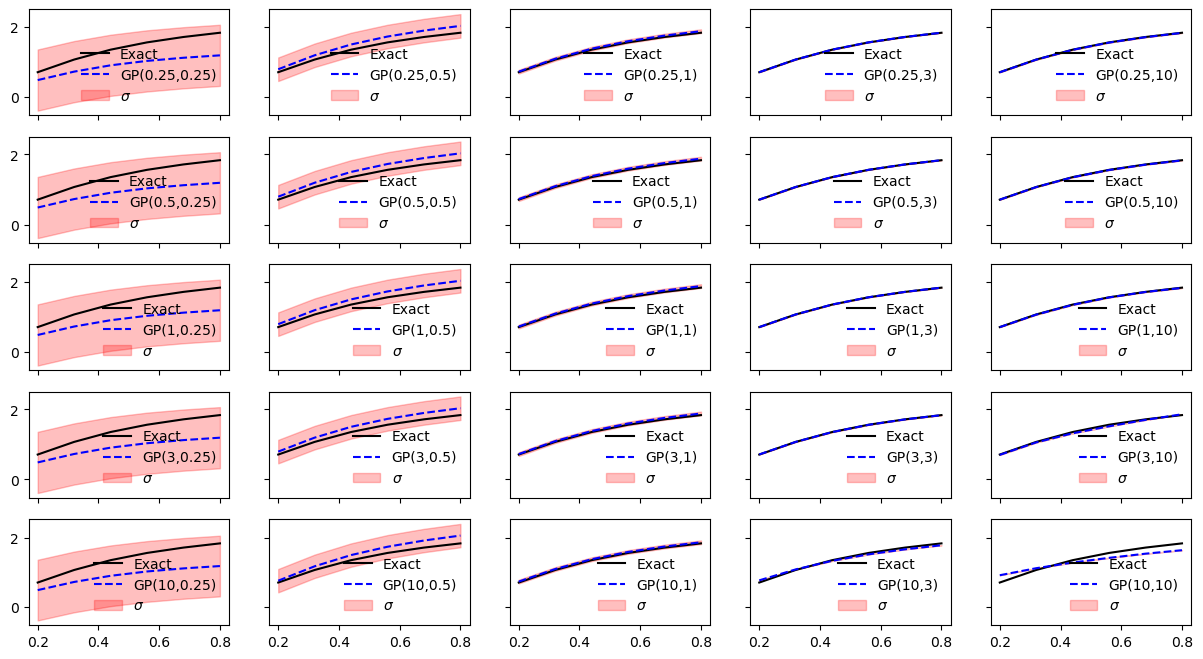

In [12]:
params = [0.25,0.5, 1, 3,10]
z = 1
fig, axs = plt.subplots(len(params),len(params), figsize=(15, 8), sharey="row", sharex="col")

for i,sp_l in enumerate(params):
    elliptic_gp.kernel_spatial.l = sp_l

    for j,sp_param in enumerate(params):
        elliptic_gp.kernel_parameter.l = sp_param

        elliptic_gp.cov_matrix = elliptic_gp.informed_kernel(elliptic_gp.parameters_data, elliptic_gp.parameters_data)
        elliptic_gp.invk_g = elliptic_gp.kernel_inverse(elliptic_gp.cov_matrix, elliptic_gp.g_trained)

        mean, var = elliptic_gp.prediction(torch.tensor(thetas[z,:]).reshape(1,-1),x_test=torch.tensor(obs_points))
        std = torch.sqrt(torch.diag(var))

        axs[i,j].plot(obs_points,training_data[z,:], color = "black", label = "Exact")
        axs[i,j].plot(obs_points,mean,linestyle="--",color = "blue", label = f"GP({sp_l},{sp_param})")
        axs[i,j].fill_between(obs_points.flatten(),mean.flatten() + std,mean.flatten() - std, color = "r", alpha= 0.25, label =r"$\sigma$")
        #axs[i,j].set_title(f"spatial, param l:({sp_l},{sp_param})")
        axs[i,j].legend(frameon=False)

In [21]:

param = torch.linspace(0.5,3,100)
res_spa = torch.zeros_like(param)
res_para = torch.zeros_like(param)
for i,sg in enumerate(param):
    
    res_spa[i] = elliptic_gp.marginal_likelihood(torch.tensor(1), torch.tensor(sg),torch.tensor(1),torch.tensor(1))
    res_para[i] = elliptic_gp.marginal_likelihood(torch.tensor(1), torch.tensor(1),torch.tensor(1),torch.tensor(sg))

Text(0.5, 0, 'l_parameter')

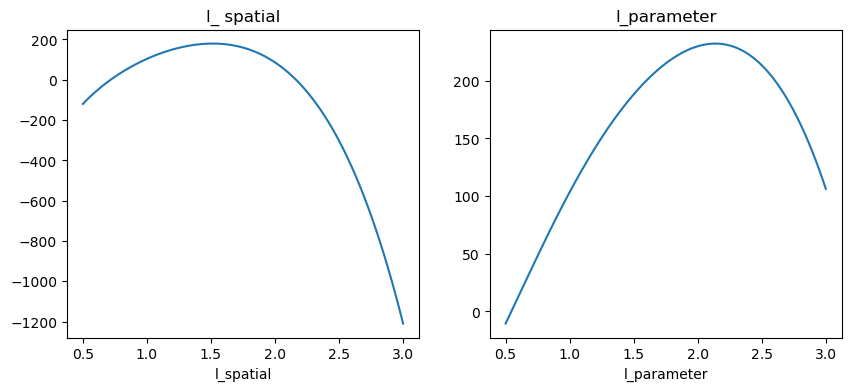

In [22]:
fig, axs = plt.subplots(1,2, figsize=(10, 4))

axs[0].plot(param,np.array(res_spa))
axs[0].set_title("l_ spatial")
axs[0].set_xlabel("l_spatial")

axs[1].plot(param,np.array(res_para))
axs[1].set_title("l_parameter")
axs[1].set_xlabel("l_parameter")


In [15]:
max_index = torch.argmax(res_spa)
print(param[max_index])
max_index = torch.argmax(res_para)
print(param[max_index])

tensor(1.5152)
tensor(2.1515)


In [16]:

param = torch.linspace(1e-3,3,100)
res_spa = torch.zeros_like(param)
res_para = torch.zeros_like(param)
for i,sg in enumerate(param):
    
    res_spa[i] = elliptic_gp.marginal_likelihood(torch.tensor(sg), torch.tensor(1),torch.tensor(1),torch.tensor(1))
    res_para[i] = elliptic_gp.marginal_likelihood(torch.tensor(1), torch.tensor(1),torch.tensor(sg),torch.tensor(1))

(-0.001, 300.0)

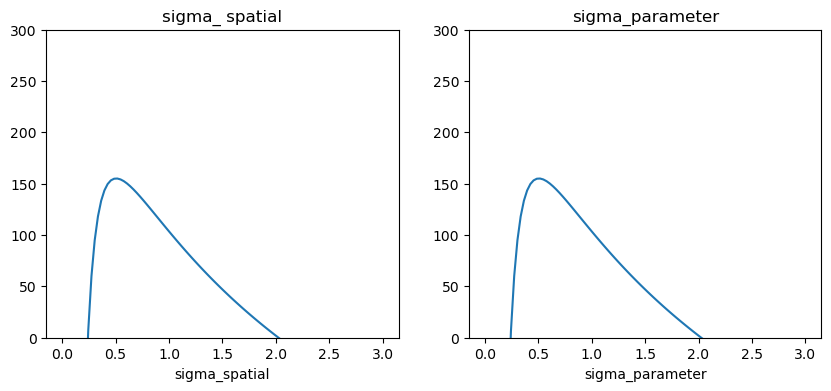

In [17]:
fig, axs = plt.subplots(1,2, figsize=(10, 4))

axs[0].plot(param,np.array(res_spa))
axs[0].set_title("sigma_ spatial")
axs[0].set_xlabel("sigma_spatial")
axs[0].set_ylim((-1e-3,300))

axs[1].plot(param,np.array(res_para))
axs[1].set_title("sigma_parameter")
axs[1].set_xlabel("sigma_parameter")
axs[1].set_ylim((-1e-3,300))


In [20]:
max_index = torch.argmax(res_spa)
print(param[max_index])
max_index = torch.argmax(res_para)
print(param[max_index])

tensor(0.5160)
tensor(0.5160)


In [21]:
elliptic_gp.optimize_mll()

Optimized parameters:
(sigma_spatial,l_spatial) = (0.8114940251313794,0.4110840074625616)
(sigma_parameter,l_parameter) = (0.8114940251492061,3.331458589376323)


Time eval: 0.3127310276031494 seconds
Time eval: 0.4385545253753662 seconds
Time eval: 0.5889003276824951 seconds
Time eval: 0.38347864151000977 seconds
Time eval: 0.5462186336517334 seconds


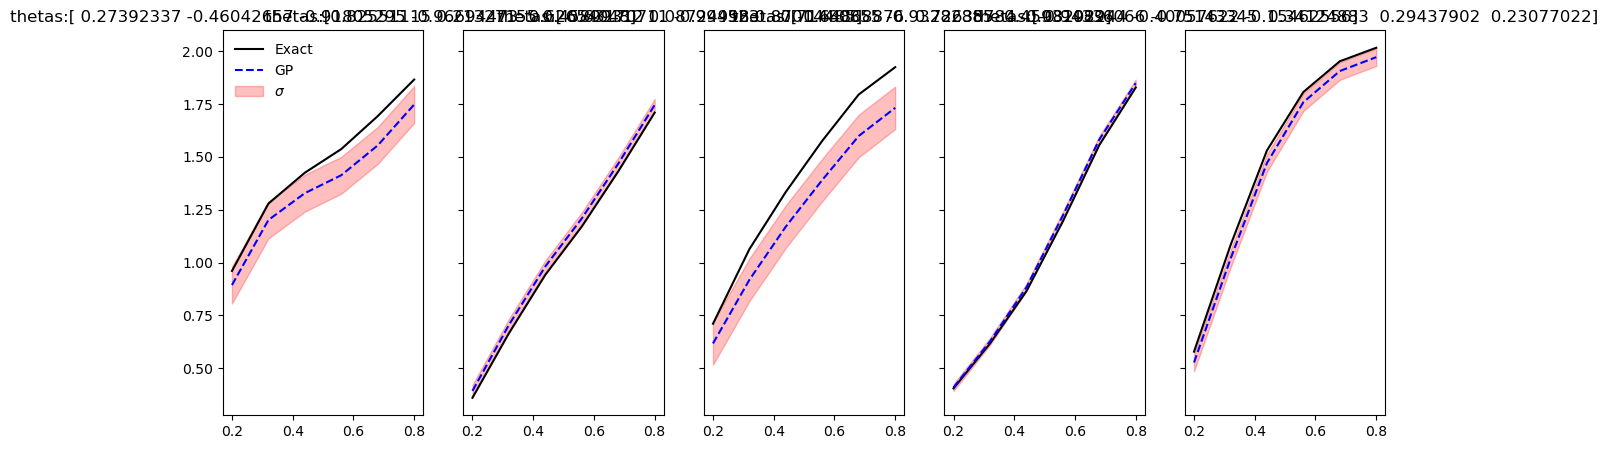

In [22]:
fig, axs = plt.subplots(1,nthetas, figsize=(15, 5), sharey="row", sharex="row")

for i in range(nthetas):
    start = time.time()
    mean, var = elliptic_gp.prediction(torch.tensor(thetas[i,:]).reshape(1,-1),x_test=torch.tensor(obs_points))
    end = time.time()
    print(f"Time eval: {end - start} seconds")

    #std = jnp.sqrt(jnp.diag(var))
    std = torch.sqrt(torch.diag(var))

    axs[i].plot(obs_points,training_data[i,:], color = "black", label = "Exact")
    axs[i].plot(obs_points,mean,linestyle="--",color = "blue", label = "GP")
    axs[i].fill_between(obs_points.flatten(),mean.flatten() + std,mean.flatten() - std, color = "r", alpha= 0.25, label =r"$\sigma$")
    axs[i].set_title(f"thetas:{thetas[i,:]}")
axs[0].legend(frameon=False)

In [14]:

import torch
from torch.distributions import MultivariateNormal

from Base.mcmc import MetropolisHastings,MCMCDA
from Base.lla import dgala

from elliptic_files.FEM_Solver import FEMSolver
from elliptic_files.elliptic import Elliptic

import time

class EllipticMCMC(MetropolisHastings):
    def __init__(self, surrogate, observation_locations, observations_values, nparameters=2, 
                 observation_noise=0.5, nsamples=1000000, burnin=None, proposal_type="random_walk",
                 step_size=0.1,uniform_limit=1,my_reg = 1e-3, device="cpu"):
        
        super(EllipticMCMC, self).__init__(observation_locations =observation_locations, observations_values=observations_values, nparameters=nparameters, 
                 observation_noise=observation_noise, nsamples=nsamples, burnin=burnin, proposal_type=proposal_type, step_size=step_size,
                 uniform_limit=uniform_limit,my_reg=my_reg,device=device)
        
        self.surrogate = surrogate
        self.device = device

        # Dictionary to map surrogate classes to their likelihood functions
        likelihood_methods = {FEMSolver: self.fem_log_likelihood,
                              EllipticPIGP:self.gp_log_likelihood,
                                   Elliptic: self.nn_log_likelihood,
                                   dgala: self.dgala_log_likelihood}

        # Precompute the likelihood function at initialization
        surrogate_type = type(surrogate)
        if surrogate_type in likelihood_methods:
            self.log_likelihood_func = likelihood_methods[surrogate_type]
        else:
            raise ValueError(f"Surrogate of type {surrogate_type.__name__} is not supported.")


    def fem_log_likelihood(self, theta ):
        """
        Evaluates the log-likelihood given a FEM.
        """
        self.surrogate.theta = theta.cpu().numpy()  # Convert to numpy for FEM solver
        self.surrogate.solve()
        surg = self.surrogate.eval_at_points(self.observation_locations.cpu().numpy()).reshape(-1, 1)
        surg = torch.tensor(surg, device=self.device)
        return -0.5 * torch.sum(((self.observations_values - surg) ** 2) / (self.observation_noise ** 2))
    
    def gp_log_likelihood(self,theta):
        """
        Evaluates the log-likelihood given a GP.
        """
        #mean_surg, var_surg = self.surrogate.prediction(jnp.array(theta.detach().numpy()).reshape(1,-1))
        #mean_surg, var_surg = self.surrogate.prediction(theta.reshape(1,-1),var=True)
        mean_surg = self.surrogate.prediction(theta.reshape(1,-1),var=False)


        #mean_surg, var_surg = torch.tensor(np.array(mean_surg)),torch.tensor(np.array(var_surg))
        dy = mean_surg.shape[0]

        diff = (self.observations_values - mean_surg.reshape(-1, 1))
        nll = -0.5 * torch.sum((diff ** 2) / (self.observation_noise ** 2))

        return nll

        # sigma = var_surg +  torch.diag(torch.ones(dy) * self.observation_noise ** 2)

        # L = torch.linalg.cholesky(sigma)
        # k_inv_g = torch.linalg.solve(sigma,diff) 

        # cte = 0.5 * (dy * torch.log(torch.tensor(2 * torch.pi)) + 2.0 * torch.sum(torch.log(torch.diag(L))))

        # # Log-likelihood
        # lg = -0.5 * torch.matmul(diff.T, k_inv_g)- cte
        # return lg.squeeze()

    def nn_log_likelihood(self, theta):
        """
        Evaluates the log-likelihood given a NN.
        """
        data = torch.cat([self.observation_locations, theta.repeat(self.observation_locations.size(0), 1)], dim=1).float()
        surg = self.surrogate.u(data.float()).detach()
        return -0.5 * torch.sum(((self.observations_values - surg) ** 2) / (self.observation_noise ** 2))

    def dgala_log_likelihood(self, theta):
        """
        Evaluates the log-likelihood given a dgala.
        """
        data = torch.cat([self.observation_locations, theta.repeat(self.observation_locations.size(0), 1)], dim=1).float()
        surg_mu, surg_sigma = self.surrogate(data)

        surg_mu = surg_mu.view(-1, 1)
        surg_sigma = surg_sigma[:, :, 0].view(-1, 1)

        sigma = self.observation_noise ** 2 + surg_sigma
        dy = surg_mu.shape[0]

        cte = 0.5 * (dy * torch.log(torch.tensor(2 * torch.pi)) + torch.sum(torch.log(sigma)))

        return -0.5 * torch.sum(((self.observations_values - surg_mu.reshape(-1, 1)) ** 2) / sigma)- cte
    
    def log_likelihood(self, theta):
        """Directly call the precomputed likelihood function."""
        return self.log_likelihood_func(theta)


In [15]:
from elliptic_files.utilities import generate_noisy_obs,deepgala_data_fit

noise_level = 1e-4
kl =2
obs_points, sol_test = generate_noisy_obs(obs=obs,
                                            std=np.sqrt(noise_level),
                                            nparam=kl,
                                            vert=50)


In [16]:
elliptic_mcmcda = EllipticMCMC(
        surrogate=elliptic_gp,
        observation_locations=obs_points,
        observations_values=sol_test,
        observation_noise=np.sqrt(noise_level),
        nparameters=kl,
        nsamples=1_500_000,
        proposal_type="pCN",
        step_size=0.01,
        uniform_limit = 1,
    )

In [17]:
gp_samples = elliptic_mcmcda.run_chain()


Running MCMC:   1%|          | 18186/1650000 [00:06<10:22, 2620.88step/s]


KeyboardInterrupt: 

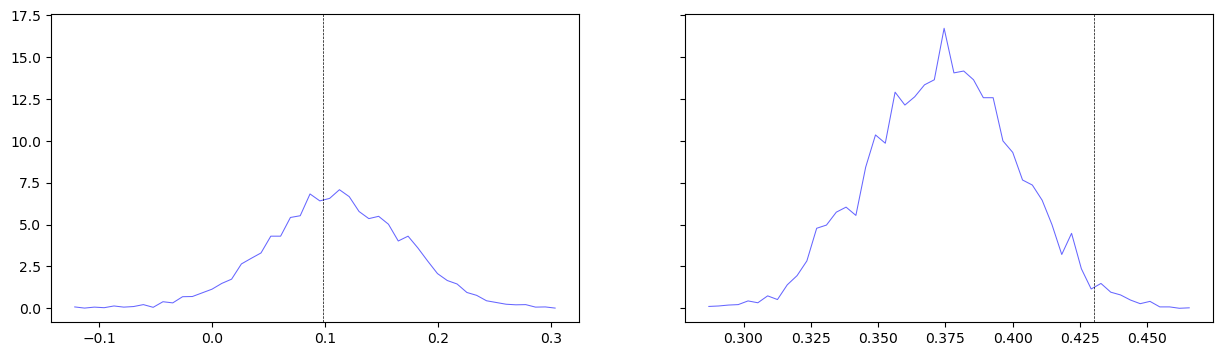

In [32]:
from Base.utilities import histogram_,stat_ar
bins = 50
theta_th =  np.array([0.098, 0.430, 0.206, 0.090, -0.153, 0.292])
#sample= np.load(f'./results/PIGP_spatial6_nsol10_kl2_var0.0001.npy')
sample = gp_samples[0]
param_dim = sample.shape[-1]

fig, axs = plt.subplots(1,param_dim, figsize=(15, 4), sharey="row", sharex="col")

for i in range(param_dim):
    bin_centers, counts = histogram_(sample[:, i],bins=bins)
    axs[i].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=0.75, label = r"$\pi_{\text{mean}}$",color = "blue")
    axs[i].axvline(x=theta_th[i], color='black', linestyle="--", linewidth=0.5)

#axs[0].set_xlim((-0.3,0.6)),axs[1].set_xlim((0.25,0.5))


In [22]:
from elliptic_files.utilities import  pigp_training_data_generation

data_training =  pigp_training_data_generation(100,6,4, device="cpu")
model = torch.load(f"./models/elliptic_pigp__spatial6_nsol100_kl4.pt")


In [40]:
obs, nthetas = 6, 10
nparams = 4
thetas  = samples_param(nthetas,nparam=nparams, seed=2)
fem_solver = FEMSolver(np.zeros(nparams),M=nparams,vert=50)
obs_points = np.linspace(0.2,0.8,obs).reshape(-1,1)
training_data = np.zeros((nthetas,obs ))

for i,theta in enumerate(thetas):
    fem_solver.theta = theta
    fem_solver.solve()
    training_data[i,:] = fem_solver.eval_at_points(obs_points).reshape(1, -1)

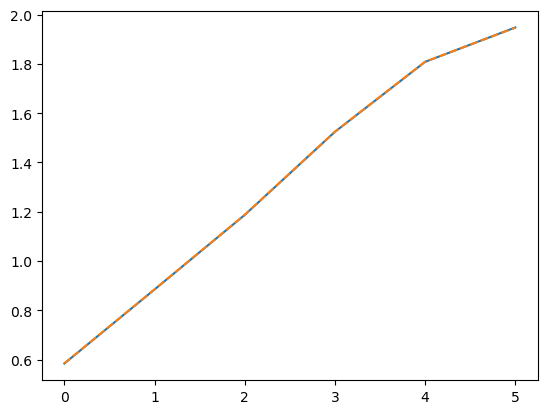

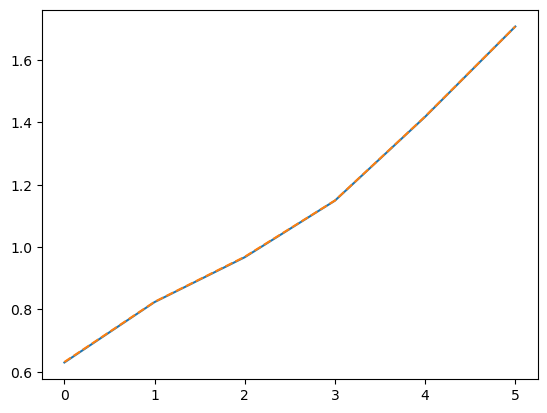

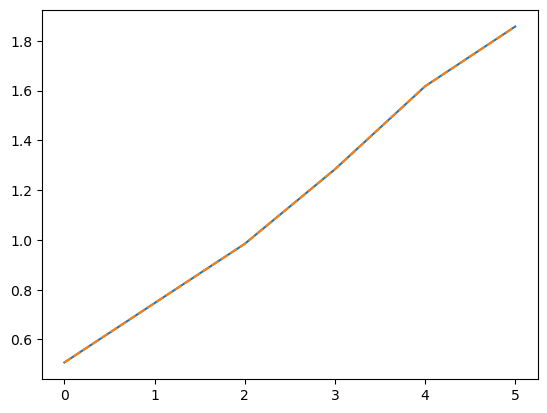

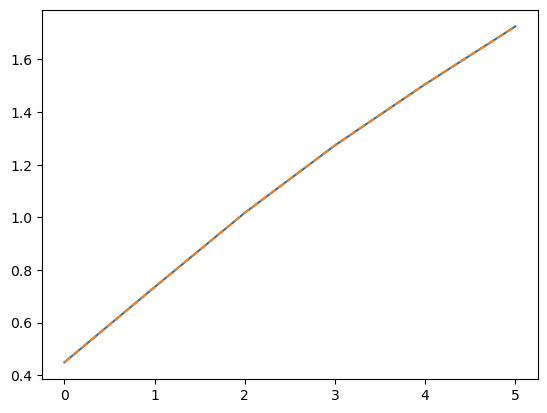

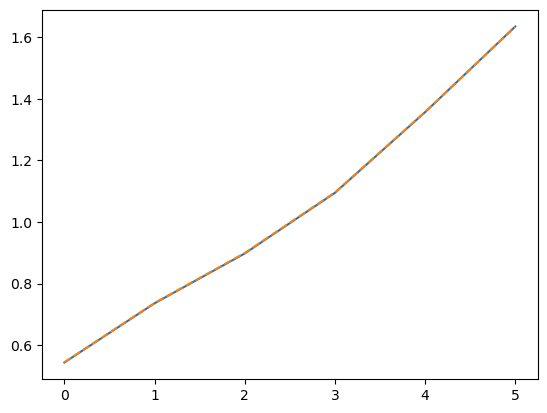

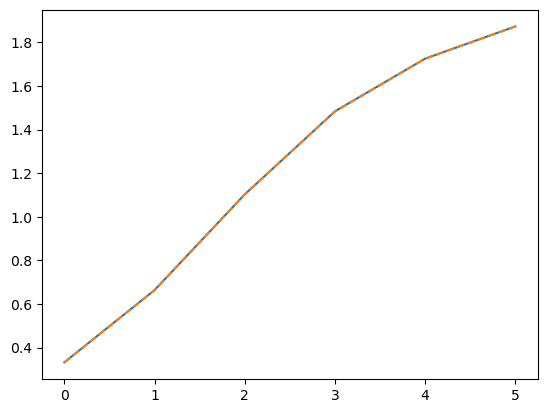

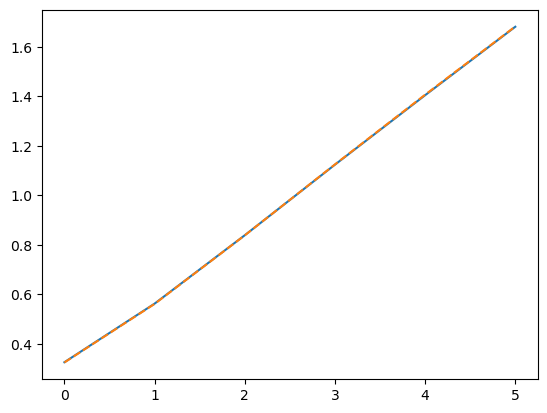

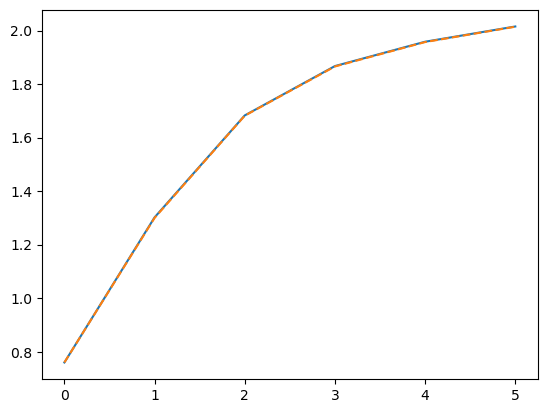

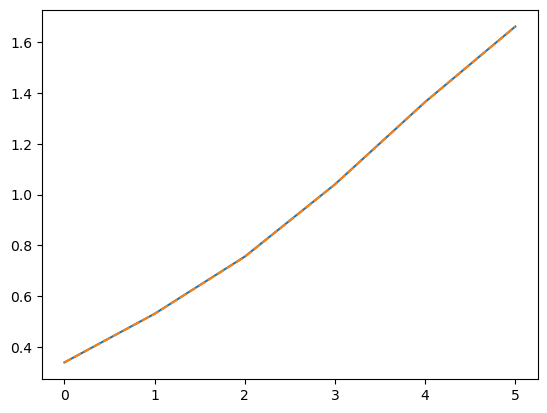

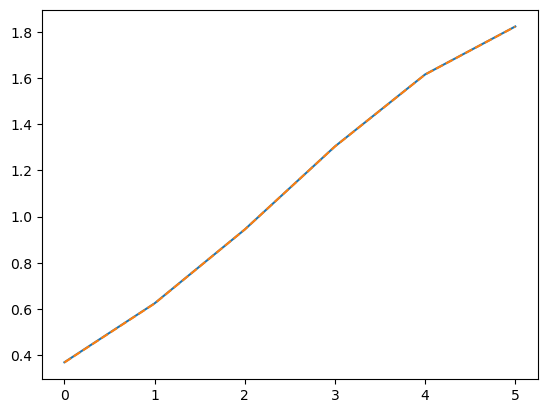

In [41]:
#y = data_training["solutions_data"]
y = training_data
#thetas = data_training["parameters_data"]

for y,th in zip(y,thetas):
    gp_pred = model.prediction(torch.tensor(th).reshape(1,-1),var=False)

    plt.plot(y)
    plt.plot(gp_pred, linestyle="--")
    plt.show()


In [29]:
th

array([ 0.38548674,  0.63163422, -0.31118648, -0.91032365])

In [ ]:

from scipy.stats import qmc

class LD_cube:
    
    def __init__(self, range_para, dimen = 1):
        
        self.dimen = dimen
        self.range_para = self.para_range_setter(range_para)
        self.points, self.V = self.para_to_points()
        
    def para_range_setter(self, range_para):
        
        if not isinstance(range_para[0],list) and self.dimen == 1:
            range_para = [range_para]
        elif not isinstance(range_para[0],list) and isinstance(self.dimen,int):
            range_para = [range_para] * self.dimen        
        
        return range_para
    
    def para_to_points(self):
                    
        samples =  self.generator()
                
        V = 1
        for j in range(self.dimen):
            samples[:,j] = (self.range_para[j][1]-self.range_para[j][0])*samples[:,j] + self.range_para[j][0]
            V = V * (self.range_para[j][1]-self.range_para[j][0])
        
        
        return samples, V
    
class Halton_cube(LD_cube):

    def __init__(self, range_para, n, dimen = 1):
        
        self.n = n
        super().__init__(range_para, dimen)
    
    def generator(self):
    
        sampler = qmc.Halton(d=self.dimen, scramble=False)
        
        return sampler.random(n=self.n)
    
class data:
    """
    Atrributes:
    k_dm: dimension of unkonwn parameters
    d_tr: number of training points
    n_ob: number of observation points
    
    U: d_tr*k_dm matrix, unknown parameters
    Y: d_tr*n_ob matrix, observational data
    xx: spatial points corresponding to observations
    
    """
    
    def __init__(self, U, Y, k_dm, xx = None):
        
        self.k_dm = k_dm
        self.d_tr = int(U.size/k_dm)
        self.n_ob = int(Y.size/self.d_tr)
        
        self.U = U
        self.Y = Y
        
        self.yy = Y.reshape(-1,1)
        self.xx = xx
        
class data_pde:
    """
    Atrributes:
    k_dm: dimension of unkonwn parameters
    d_tr: number of training points
    n_ob: number of observation points
    
    U: d_tr*k_dm matrix, unknown parameters
    Y: d_tr*n_ob matrix, observational data
    xx: spatial points corresponding to observations
    
    """
    
    def __init__(self, Xbc, ybc, Xf, Yf, k_dm):
        
        self.k_dm = k_dm
        self.d_tr = int(Xf.size/k_dm)
        self.n_ob = int(Yf.size/self.d_tr)
        
        self.Xbc = Xbc
        self.ybc = ybc
        
        self.Xf = Xf
        self.Yf = Yf        
        
        self.yf = Yf.reshape(-1,1)

In [ ]:
import numpy as np
from scipy.spatial import distance_matrix


class kernel_function:
    def __init__(self, dimen):
        
        self.dimen = dimen
        self.K = self.cov
    
    def parameter_formalizer(self, para):
        
        para = np.atleast_2d(para).reshape(-1,1)
        
        return para
    
    def input_formalizer(self, x):
        
        return np.atleast_2d(x).reshape(-1,self.dimen)
    
    def weighted_dist_mat(self, l, x1, x2 = None):
        
        if x2 is None:
            x2 = np.copy(x1)
            
        x1 = np.atleast_2d(x1).reshape(-1,self.dimen)
        x2 = np.atleast_2d(x2).reshape(-1,self.dimen)
 
        return distance_matrix(x1/l,x2/l)
 
    def cov(self, x1, x2, n_ob):
        
        raise NotImplementedError(
            'Function cov not implemented. Please initilize a specific kernel function.')
        
    def cov_3d(self, x1, x2, n_ob):
        cov_mat = self.cov(x1,x2)
        a,b = np.shape(cov_mat)
        
        return np.broadcast_to(cov_mat,(n_ob,a,b))
    
    def cov_kron(self, x1, x2, n_ob, Spatial_cov = None):
        
        if Spatial_cov is None:
            Spatial_cov = np.eye(n_ob)
            
        cov_mat = self.cov(x1,x2)
        
        return np.kron(Spatial_cov,cov_mat)
    
class kernel_squared_exponential(kernel_function):
    
    def __init__(self, sigma_square, l, dimen = 1):
        
        self.sigma_square = sigma_square      
        self.l = self.parameter_formalizer(l)  
        self.dimen = dimen
        
        super().__init__(dimen)
        
    def cov(self, x1, x2 = None):
        
        d = self.weighted_dist_mat(self.l, x1, x2)
        
        return self.sigma_square * np.exp(-d**2/2)
    
    def cov_prime(self, x1, x2):
        
        return (-(x1.T-x2.T)/(self.l)**2) * self.cov(x1,x2)


In [ ]:
import numpy as np
import jax.numpy as jnp

# Load the data using NumPy
u_Theta = np.loadtxt("2D_trainingset_N10.txt")


# Number of spatial oberservation points
dy = 6
X = np.linspace(0,1,dy)

# Convert to jax.numpy
#u_Theta = jnp.array(data_np)

N = 10
Theta_train = Halton_cube([-1,1], N+1, 2).points[1:,:]

print(Theta_train.shape,u_Theta.shape,X.shape)
tr_data = data(Theta_train, u_Theta.T, 2, X)


(10, 2) (6, 10) (6,)


In [ ]:
obs, nthetas = 6, 10
thetas  = samples_param(nthetas,nparam=2)
fem_solver = FEMSolver(np.zeros(2),vert=50)
obs_points = np.linspace(0.2,0.8,obs).reshape(-1,1)
training_data = np.zeros((nthetas,obs ))

for i,theta in enumerate(thetas):
    fem_solver.theta = theta
    fem_solver.solve()
    training_data[i,:] = fem_solver.eval_at_points(obs_points).reshape(1, -1)

In [ ]:
training_data.shape

(10, 6)

In [ ]:
class Gp_regression:
    def __init__(self, kernel, tr_data, normalizer = 10**(-10), prior_mean = 0):
        
        self.k_dm = tr_data.k_dm
        self.d_tr = tr_data.d_tr
        self.n_ob = tr_data.n_ob
        
        self.mean = prior_mean
        self.k = kernel
        self.tr_data = tr_data
                
        self.normalizer = normalizer
                
        self.K_inv_y, self.K_tr_tr = self.inverse_precomputer()

       
    def inverse_precomputer(self):
        
        K_tr_tr = self.k.cov(self.tr_data.U)   
        K_tr_tr = np.kron(K_tr_tr, np.eye(self.n_ob)) + self.normalizer * np.eye(self.n_ob*self.d_tr)

        K_inv_y = np.linalg.solve(K_tr_tr, self.tr_data.yy - self.mean)
        
        return K_inv_y, K_tr_tr
    
    
    def predict_mean(self, test_u):
        
        K_test_tr = self.k.cov(test_u,self.tr_data.U)
        K_test_tr = np.kron(K_test_tr, np.eye(self.n_ob))#self.extend(K_test_tr)
            
        pred_mean = self.mean + K_test_tr @ self.K_inv_y
                
        return pred_mean
    
    
    def predict_var(self, test_u):
        
        K_test_tr = np.kron(self.k.cov(test_u, self.tr_data.U),np.eye(self.n_ob))
        K_tr_test = np.kron(self.k.cov(self.tr_data.U, test_u),np.eye(self.n_ob)) 
        
        pred_var = np.kron(self.k.cov(test_u), np.eye(self.n_ob))- K_test_tr @ np.linalg.solve(self.K_tr_tr, K_tr_test)
        
        return pred_var
    
    def predict_vars(self, test_u):

        pred_vars = np.zeros((len(test_u),self.n_ob,self.n_ob))
        
        i = 0
        for u in test_u:
            pred_vars[i,:,:] = self.predict_var(u)
            i = i + 1
        
        return pred_vars

    def pred_mean_prime(self, test_u, X = None):
        
        cov_prime = self.k.cov_prime(test_u,self.tr_data.U)
        mean_prime = np.kron(cov_prime, np.eye(self.n_ob)) @ self.K_inv_y
        
        return mean_prime
    
    def pred_var_prime(self, test_u):
        
        pred_var_prime = np.zeros((self.k_dm,self.n_ob,self.n_ob))
        cov_prime = self.k.cov_prime(test_u,self.tr_data.U)
        
        K_tr_test = np.kron(self.k.cov(self.tr_data.U, test_u), np.eye(self.n_ob))
        var_prime = np.kron(cov_prime, np.eye(self.n_ob)) @ np.linalg.solve(self.K_tr_tr, K_tr_test) 
        
        for i in range(self.k_dm):
            pred_var_prime[i,:,:] = var_prime[i::self.k_dm,:]

        return -2 * pred_var_prime
    
    
    
    
class Spc_Gpr(Gp_regression):
    
    def __init__(self, kernel, tr_data, kernel_x, normalizer = 10**(-10), prior_mean = 0):
        
        self.kx = kernel_x
        self.xx = tr_data.xx
        
        super().__init__(kernel, tr_data, normalizer, prior_mean)
        
        
    def inverse_precomputer(self):
        
        K_tr_tr = self.k.cov(self.tr_data.U)         
        K_tr_tr = np.kron(K_tr_tr, self.kx.cov(self.xx)) + self.normalizer * np.eye(self.n_ob*self.d_tr)
        
        K_inv_y = np.linalg.solve(K_tr_tr, self.tr_data.yy - self.mean)
        
        return K_inv_y, K_tr_tr
    
    
    def predict_mean(self, test_u, X = None):
        
        if X is None: X = self.xx
        
        K_test_tr = self.k.cov(test_u,self.tr_data.U)
        K_test_tr = np.kron(K_test_tr, self.kx.cov(X, self.xx) )#self.extend(K_test_tr)
            
        pred_mean = self.mean + K_test_tr @ self.K_inv_y
                
        return pred_mean.reshape(len(X), -1)
    
    
    def predict_var(self, test_u, X = None):
        
        if X is None: X = self.xx
        
        K_test_tr = np.kron(self.k.cov(test_u, self.tr_data.U),self.kx.cov(X, self.xx))
        K_tr_test = np.kron(self.k.cov(self.tr_data.U, test_u),self.kx.cov(self.xx, X)) 
        
        pred_var = np.kron(self.k.cov(test_u), self.kx.cov(X))- K_test_tr @ np.linalg.solve(self.K_tr_tr, K_tr_test)
        
        return pred_var

    def pred_mean_prime(self, test_u, X = None):
        
        if X is None: X = self.xx
        
        cov_prime = self.k.cov_prime(test_u,self.tr_data.U)
        mean_prime = np.kron(cov_prime, self.kx.cov(X, self.xx)) @ self.K_inv_y
        
        
        return mean_prime
    
    def pred_var_prime(self, test_u, X = None):
        
        if X is None: X = self.xx
        
        pred_var_prime = np.zeros((self.k_dm,self.n_ob,self.n_ob))
        cov_prime = self.k.cov_prime(test_u,self.tr_data.U)
        
        K_tr_test = np.kron(self.k.cov(self.tr_data.U, test_u),self.kx.cov(self.xx, X))
        var_prime = np.kron(cov_prime, self.kx.cov(X, self.xx)) @ np.linalg.solve(self.K_tr_tr, K_tr_test) 
        
        for i in range(self.k_dm):
            pred_var_prime[i,:,:] = var_prime[i::self.k_dm,:]

        return -2 * pred_var_prime

class PDE_Gpr(Gp_regression):
    
    def __init__(self, kernel, tr_data, kernel_x, pde_data, normalizer = 10**(-10), prior_mean = 0):
        
        self.kx = kernel_x
        self.xx = tr_data.xx
        
        self.d_f = pde_data.d_tr       
        
        self.xxu = pde_data.Xbc
        self.yu = pde_data.ybc
        
        self.xxf = pde_data.Xf
        self.yf = pde_data.yf
 
        self.yy = tr_data.yy.reshape(tr_data.d_tr,tr_data.n_ob)[:,1:-1].reshape(-1,1)
        super().__init__(kernel, tr_data, normalizer, prior_mean)
        
   #     spc_Gpr = Spc_Gpr(kernel,tr_data,kernel_x)
  #      self.pred_mean_prime = spc_Gpr.pred_mean_prime
 #       self.pred_var_prime = spc_Gpr.pred_var_prime
        
    def inverse_precomputer(self):
        
        K_tr_tr = np.zeros(((self.n_ob-2)*self.d_tr,(self.n_ob-2)*self.d_tr))
        
        for i in range(self.d_tr):
            for j in range(self.d_tr):
                K_tr_tr[i*(self.n_ob-2):(i+1)*(self.n_ob-2),j*(self.n_ob-2):(j+1)*(self.n_ob-2)] = self.Condp_spc(self.tr_data.U[i],self.tr_data.U[j],self.xx[1:-1],self.xx[1:-1]) * self.k.cov(self.tr_data.U[i],self.tr_data.U[j]) 
           
        
        K_tr_tr = K_tr_tr + self.normalizer*np.eye((self.n_ob-2)*self.d_tr)
        
        Condmean_XU = np.zeros((self.d_tr*(self.n_ob-2), 1))        
        for i in range(self.d_tr):
            Condmean_XU[i*(self.n_ob-2):(i+1)*(self.n_ob-2),:] = self.Condp_mean(self.tr_data.U[i],self.xx[1:-1]) 
            
        self.Condmean_XU = Condmean_XU
        K_inv_y = np.linalg.solve(K_tr_tr, (self.yy - Condmean_XU))
        
        return K_inv_y, K_tr_tr
    
    def K_uf(self, u1, X):
        


        lam = 1/4
        theta = np.array([0.38762262, 0.21646897])
        A = np.array([1.05705812, 0.84367913])
        omega = np.array([2.15374797, 4.57785946])
        
        u1 = np.atleast_2d(u1).reshape(1,2)        
        
        def cossin(u, x):
      
            z = 0
            for j in range(2):
                z = z + np.sqrt(theta[j])*u[0][j]*A[j]*(omega[j]*np.cos(omega[j]*x) - lam*omega[j]**2*np.sin(omega[j]*x))

            return z

        def sincos(u, x):

            z = 0
            for j in range(2):
                z = z + np.sqrt(theta[j])*u[0][j]*A[j]*(np.sin(omega[j]*x) + lam*omega[j]*np.cos(omega[j]*x))
                
            return z  
  
        sincos_mat = np.zeros((len(X),self.d_f))
        cossin_mat = np.zeros((len(X),self.d_f))        

        for j in range(self.d_f):
            sincos_mat[:,j] = sincos(u1,self.xxf[j])
            cossin_mat[:,j] = cossin(u1,self.xxf[j])
        
        diff = X.reshape(-1,1)-self.xxf
        #d = self.kx.weighted_dist_mat(1, X, self.xxf)  
        LK = ((self.kx.l**2 - diff**2)*np.exp(sincos_mat) - self.kx.l**2 * diff * cossin_mat * np.exp(sincos_mat))/self.kx.l**4
        mat = LK * self.kx.cov(X,self.xxf)
        
        return mat
    
    def K_ff(self, u1, u2):


        lam = 1/4
        theta = np.array([0.38762262, 0.21646897])
        A = np.array([1.05705812, 0.84367913])
        omega = np.array([2.15374797, 4.57785946])
        
        u1 = np.atleast_2d(u1).reshape(1,2)
        u2 = np.atleast_2d(u2).reshape(1,2)  
        
        def cossin(u, x):
            z = 0
            for j in range(2):
                z = z + np.sqrt(theta[j])*u[0][j]*A[j]*(omega[j]*np.cos(omega[j]*x) - lam*omega[j]**2*np.sin(omega[j]*x))

            return z

        def sincos(u, x):
            z = 0            
            for j in range(2):
                z = z + np.sqrt(theta[j])*u[0][j]*A[j]*(np.sin(omega[j]*x) + lam*omega[j]*np.cos(omega[j]*x))

            return z          
        
        sincos_mat1 = np.zeros((self.d_f,self.d_f))
        sincos_mat2 = np.zeros((self.d_f,self.d_f))
        cossin_mat1 = np.zeros((self.d_f,self.d_f))
        cossin_mat2 = np.zeros((self.d_f,self.d_f))
      

        for j in range(self.d_f):
            sincos_mat1[:,j] = sincos(u1,self.xxf[j])
            cossin_mat1[:,j] = cossin(u1,self.xxf[j])
            sincos_mat2[:,j] = sincos(u2,self.xxf[j])
            cossin_mat2[:,j] = cossin(u2,self.xxf[j])
            
        diff = (self.xxf.reshape(-1,1)-self.xxf)/self.kx.l**2
        #d = self.kx.weighted_dist_mat(self.kx.l**2, self.xxf, self.xxf)  
        #LLK = (diff**4 + (cossin_mat2 - cossin_mat1.T)*diff**3 - (6/self.kx.l**2 + cossin_mat1.T*cossin_mat2) *diff**2 + (3*(cossin_mat1.T - cossin_mat2)/self.kx.l**2)*diff + cossin_mat1.T*cossin_mat2/self.kx.l**2 + 3/self.kx.l**4) * np.exp(sincos_mat2) * np.exp(sincos_mat1.T) 
        LLK = (diff**4 + (cossin_mat2 - cossin_mat1.T)*diff**3 - (2/self.kx.l**2 + cossin_mat1.T*cossin_mat2) *diff**2 + ((3*cossin_mat1.T - cossin_mat2)/self.kx.l**2)*diff + cossin_mat1.T*cossin_mat2/self.kx.l**2  + 3/self.kx.l**4) * np.exp(sincos_mat2) * np.exp(sincos_mat1.T) 
        mat = LLK * self.kx.cov(self.xxf,self.xxf)
        return LLK    


    def pde_K(self, u1, u2):
        
        Kuu = self.kx.cov(self.xxu) 
        Kuf = self.K_uf(u2, self.xxu)
        Kfu = self.K_uf(u1, self.xxu).T
        Kff = self.K_ff(u1,u2)
        
        return np.vstack(( np.hstack((Kuu,Kuf)) , np.hstack((Kfu,Kff)) ))

    def Condp_spc(self, u1, u2, x1, x2):
        
        Kuu = self.kx.cov(x1, self.xxu)
        Kuf = self.K_uf(u2, x1)
        qu  = np.hstack((Kuu, Kuf))
        
        Kuu = self.kx.cov(x2, self.xxu)
        Kuf = self.K_uf(u1, x2)
        quT  = np.hstack((Kuu, Kuf)).T
        
        return (self.kx.cov(x1,x2) - qu@np.linalg.solve(self.pde_K(u1,u2),quT)) 
    
    def Condp_mean(self, u1, x1):
        
        Kuu = self.kx.cov(x1, self.xxu)
        Kuf = self.K_uf(u1, x1)
        qu  = np.hstack((Kuu, Kuf))

        return (qu @ np.linalg.solve(self.pde_K(u1,u1), np.vstack((self.yu,self.yf))))  
    
    
    def predict_mean(self, u, x = None):
        
        if x is None: x = self.xx
        
        Condmean_xu = self.Condp_mean(u,x)
                
        KuU = np.zeros((len(x),(self.n_ob-2)*self.d_tr))
        for i in range(self.d_tr):
            KuU[:,i*(self.n_ob-2):(i+1)*(self.n_ob-2)] = self.Condp_spc(u,self.tr_data.U[i],x,self.xx[1:-1])* self.k.cov(u,self.tr_data.U[i])  
           
        
        return Condmean_xu + KuU @ self.K_inv_y
    
    
    def predict_var(self, u, x = None):
        
        if x is None: x = self.xx
        
        Kuu = self.Condp_spc(u,u,x,x) * self.k.cov(u,u)
        
        KuU = np.zeros((len(x),(self.n_ob-2)*self.d_tr))
        for i in range(self.d_tr):
            KuU[:,i*(self.n_ob-2):(i+1)*(self.n_ob-2)] = self.Condp_spc(u,self.tr_data.U[i],x,self.xx[1:-1]) * self.k.cov(u,self.tr_data.U[i])      
        
        return Kuu - KuU @ np.linalg.solve(self.K_tr_tr, KuU.T)  
    
    

    
    
    def pred_mean_prime(self, u, x = None):
        
        if x is None: x = self.xx
            
        KuU = np.zeros((self.k_dm*len(x),(self.n_ob-2)*self.d_tr))        
        for i in range(self.d_tr):
            KuU[:,i*(self.n_ob-2):(i+1)*(self.n_ob-2)] = np.kron(self.k.cov_prime(u.reshape(1,self.k_dm),self.tr_data.U[i].reshape(1,self.k_dm))  ,self.Condp_spc(u,self.tr_data.U[i],x,self.xx[1:-1]))
   
        mean_prime = KuU @ self.K_inv_y
        
        
        return mean_prime
    
    def pred_var_prime(self, u, x = None):
        
        if x is None: x = self.xx
        
        pred_var_prime = np.zeros((self.k_dm,(self.n_ob),(self.n_ob)))
        cov_prime = self.k.cov_prime(u,self.tr_data.U)

        KUu = np.zeros(((self.n_ob-2)*self.d_tr,len(x)))
        for i in range(self.d_tr):
            KUu[i*(self.n_ob-2):(i+1)*(self.n_ob-2),:] = self.Condp_spc(self.tr_data.U[i], u,self.xx[1:-1],x) * self.k.cov(self.tr_data.U[i],u)
            
        KuU = np.zeros((self.k_dm*len(x),(self.n_ob-2)*self.d_tr))        
        for i in range(self.d_tr):
            KuU[:,i*(self.n_ob-2):(i+1)*(self.n_ob-2)] = np.kron(self.k.cov_prime(u.reshape(1,2),self.tr_data.U[i].reshape(1,2))  ,self.Condp_spc(u,self.tr_data.U[i],x,self.xx[1:-1]))
        

        var_prime = KuU @ np.linalg.solve(self.K_tr_tr, KUu) 
        
        for i in range(self.k_dm):
            pred_var_prime[i,:,:] = var_prime[i::self.k_dm,:]

        return -2 * pred_var_prime    
    

In [ ]:
tr_data = data(thetas, training_data, 2, obs_points.reshape(-1,))


In [ ]:
kernel = kernel_squared_exponential(1,1, dimen = 2)
Gpr = Gp_regression(kernel,tr_data)

def neg_log_marginal_likelihood(hyp):  # ML_GPR

    kernel = kernel_squared_exponential(hyp[0], hyp[1], dimen = 2)
    Gpr = Gp_regression(kernel,tr_data)
    
    K = Gpr.K_tr_tr

    eig_v = np.linalg.eigvals(K)

    L = np.linalg.cholesky(K)
    y = tr_data.yy
    nlml = sum(np.log(np.diag(L))) + 0.5*np.matmul(y.T,np.linalg.solve(K,y))[0] + 0.5*60*np.log(2*np.pi)

    return nlml

neg_log_marginal_likelihood(np.array([1.0, 1.0]))

from scipy.optimize import minimize

hyp = np.array([1,1])
bound = [[10**(-10), 100] for i in range(len(hyp))]
hyp1 = minimize(neg_log_marginal_likelihood, hyp, method = 'L-BFGS-B', bounds = bound)
print("Optimized hyperparameter:",hyp1.x)

kernel = kernel_squared_exponential(*hyp1.x, dimen = 2)
Gpr = Gp_regression(kernel,tr_data)

print(Gpr.predict_mean(np.array([[0.098, 0.430]])))
print(Gpr.predict_var(np.array([[0.098, 0.430]])))

Optimized hyperparameter: [1.57410073 4.23240861]
[[0.42518855]
 [0.66964511]
 [0.92114373]
 [1.18377489]
 [1.45010828]
 [1.69917492]]
[[8.26246152e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 8.26246152e-07 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 8.26246153e-07 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.26246153e-07
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.26246153e-07 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 8.26246153e-07]]


In [ ]:
def neg_log_marginal_likelihood2(hyp):  # ML_GPR

    kernel = kernel_squared_exponential(hyp[0], hyp[1], dimen = 2)
    kx = kernel_squared_exponential(1, hyp[3], dimen = 1)
    spc_Gpr = Spc_Gpr(kernel,tr_data,kx)
    
    K = spc_Gpr.K_tr_tr
    eig_v = np.linalg.eigvals(K)

    L = np.linalg.cholesky(K)
    y = tr_data.yy
    nlml = 0.5*sum(np.log(np.diag(L))) + 0.5*np.matmul(y.T,np.linalg.solve(K,y))[0] + 0.5*60*np.log(2*np.pi)

    return nlml

hyp = np.array([8,9,1,0.1])
bound = [[10**(-10), 100] for i in range(len(hyp))]
hyp2 = minimize(neg_log_marginal_likelihood2, hyp, method = 'L-BFGS-B', bounds = bound)
print("Optimized hyperparameter:",hyp2.x)

kernel = kernel_squared_exponential(hyp1.x[0],hyp1.x[1], dimen = 2)
kx = kernel_squared_exponential(1, hyp[-1], dimen = 1)
Gpr = Spc_Gpr(kernel,tr_data,kx)

print(Gpr.predict_mean(np.array([[0.098, 0.430]])))
print(Gpr.predict_var(np.array([[0.098, 0.430]])))

Optimized hyperparameter: [7.56931582 5.61604521 1.         0.20870697]
[[0.42518839]
 [0.6696448 ]
 [0.92114354]
 [1.1837749 ]
 [1.45010867]
 [1.69917515]]
[[8.26245905e-07 4.01896176e-07 4.63483886e-08 1.26655065e-09
  8.13775813e-12 3.50279817e-14]
 [4.01896176e-07 8.26245565e-07 4.01896350e-07 4.63483081e-08
  1.26658187e-09 8.13775965e-12]
 [4.63483886e-08 4.01896350e-07 8.26245481e-07 4.01896383e-07
  4.63483080e-08 1.26655065e-09]
 [1.26655066e-09 4.63483081e-08 4.01896382e-07 8.26245483e-07
  4.01896348e-07 4.63483884e-08]
 [8.13775849e-12 1.26658186e-09 4.63483081e-08 4.01896349e-07
  8.26245568e-07 4.01896176e-07]
 [3.50281077e-14 8.13775947e-12 1.26655066e-09 4.63483886e-08
  4.01896178e-07 8.26245906e-07]]


In [ ]:
gp = GaussianProcess(thetas,training_data,x_spc=obs_points)

print(gp.neg_log_likelihood(jnp.array([1.0, 1.0,1.0])))

gp.optimize_nll(jnp.array([1.0, 1.0,1.0]))

print(gp.opt_params,gp.opt_params_spc)

print(gp.predict_mean(jnp.array([[0.098, 0.430]])))

print(gp.predict_var(jnp.array([[0.098, 0.430]])))

7464.237732719945
[0.85123893 3.73468095] 0.24955226043524195
[0.42498576 0.66927244 0.92063745 1.18318627 1.44953751 1.69878167]
[[1.13418078e-06 9.00092243e-07 1.29219642e-06 7.91787320e-07
  9.79708166e-07 3.17428682e-07]
 [1.12018215e-06 1.06976342e-06 1.70701853e-06 1.24662449e-06
  1.47410006e-06 5.08108527e-07]
 [9.36357633e-07 1.03739503e-06 1.83274999e-06 1.60349780e-06
  1.82858790e-06 7.07305839e-07]
 [6.78617033e-07 8.16117738e-07 1.57861400e-06 1.67418471e-06
  1.87906303e-06 8.78804086e-07]
 [4.33871908e-07 5.11793338e-07 1.07440841e-06 1.41191036e-06
  1.60469503e-06 9.77894550e-07]
 [2.45111850e-07 2.46522849e-07 5.63864170e-07 9.60645847e-07
  1.13829896e-06 9.54000651e-07]]


In [ ]:
Xf = np.linspace(0.,1,10)
print("Observation points for the sourcing function:",Xf)
yf = (4*Xf).reshape(-1,1) # training data
Xbc = np.array([0,1])
ybc = np.array([0,2]).reshape(-1,1)
df = data_pde(Xbc, ybc, Xf, yf, 1)

Observation points for the sourcing function: [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]


In [ ]:
def neg_log_marginal_likelihood3(hyp):  # ML_GPR
    print(hyp)
    kernel = kernel_squared_exponential(hyp[0], hyp[1], dimen = 2)
    kx = kernel_squared_exponential(1, hyp[3], dimen = 1)
    pde_Gpr = PDE_Gpr(kernel,tr_data,kx,df,normalizer=10**(-10))
    
    K = pde_Gpr.K_tr_tr
    eig_v = np.linalg.eigvals(K)

    L = np.linalg.cholesky(K)
    y = pde_Gpr.yy
    nlml = 0.5*sum(np.log(np.diag(L))) + 0.5*np.matmul(y.T,np.linalg.solve(K,y))[0] + 0.5*N*np.log(2*np.pi)

    return nlml

Xf = np.linspace(0.,1,10)
print("Observation points for the sourcing function:",Xf)
yf = (4*Xf).reshape(-1,1) # training data
Xbc = np.array([0,1])
ybc = np.array([0,2]).reshape(-1,1)
df = data_pde(Xbc, ybc, Xf, yf, 1)

hyp = hyp2.x
bound = [[10**(-2), 100] for i in range(len(hyp))]
# hyp3 = minimize(neg_log_marginal_likelihood3, hyp, method = 'L-BFGS-B', bounds = bound)

Observation points for the sourcing function: [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]


In [ ]:
kernel = kernel_squared_exponential(1, 1, dimen = 2)
kx = kernel_squared_exponential(1, 1, dimen = 1)
pde_Gpr = PDE_Gpr(kernel, tr_data, kx, df)
pde_Gpr.K_uf(pde_Gpr.tr_data.U[0],pde_Gpr.xxu)

array([[ 1.19692243,  1.19835481,  0.80876289,  0.26770657, -0.10837473,
        -0.21351692, -0.11943765,  0.08673703,  0.37427721,  0.74925105],
       [-0.52198305,  0.27218589,  1.04447398,  1.38866671,  1.27227964,
         0.94673965,  0.64357261,  0.46291042,  0.43482834,  0.59519506]])

In [ ]:
pde_Gpr.pde_K(pde_Gpr.tr_data.U[0],pde_Gpr.tr_data.U[2])

array([[ 1.        ,  0.60653066,  1.35155109,  1.67335813,  1.84912035,
         1.79643974,  1.48593106,  0.96354869,  0.33925008, -0.25462605,
        -0.71205798, -0.98332582],
       [ 0.60653066,  1.        , -0.98781687, -0.7142532 , -0.25313296,
         0.34405576,  0.96942897,  1.49009256,  1.79734593,  1.84734067,
         1.67084508,  1.35012795],
       [ 1.19692243, -0.52198305,  6.25471589,  6.53666448,  6.31144085,
         5.51836399,  4.26481651,  2.82266888,  1.54351158,  0.72957167,
         0.52909866,  0.9081443 ],
       [ 1.19835481,  0.27218589,  4.42819255,  5.43533593,  6.29100835,
         6.80474229,  6.85095576,  6.43025293,  5.67870211,  4.81453137,
         4.05184939,  3.52950755],
       [ 0.80876289,  1.04447398,  1.16000287,  2.56998096,  4.28216421,
         6.0485968 ,  7.55484965,  8.52411641,  8.81715311,  8.4740356 ,
         7.67859009,  6.67320785],
       [ 0.26770657,  1.38866671, -1.65129086, -0.35909027,  1.53525272,
         3.81833502,  

In [ ]:
xf = jnp.linspace(0.,1,10)
yf = (4*Xf).reshape(-1,1) # training data
x_bc = jnp.array([0,1]).reshape(-1,1)
y_bc = jnp.array([0,2]).reshape(-1,1)

data_training = {"parameters_data": thetas,
                 "solutions_data": training_data,
                 "x_bc": x_bc,
                 "y_bc": y_bc,
                 "source_func_x": xf,
                 "source_func_f_x":yf
                   }
elliptic_gp = EllipticPIGP(data_training)

KeyError: 'x_solutions_data'

In [ ]:
elliptic_gp.kernel_ff(pde_Gpr.tr_data.U[0],pde_Gpr.tr_data.U[2])

Array([[ 6.25471595,  6.49643904,  6.15751104,  5.22014869,  3.86373264,
         2.41901842,  1.2359474 ,  0.53914706,  0.35642117,  0.55081734],
       [ 4.40094225,  5.43533597,  6.25229463,  6.63878134,  6.48072651,
         5.82552105,  4.86663007,  3.85517535,  2.99428143,  2.37761201],
       [ 1.13171151,  2.55416574,  4.28216422,  6.01137482,  7.37059433,
         8.06346871,  7.98794571,  7.26222223,  6.14853434,  4.93144256],
       [-1.56205429, -0.35033247,  1.52580501,  3.81833502,  6.08350764,
         7.83000986,  8.7099543 ,  8.64405354,  7.81450596,  6.54835166],
       [-2.44703619, -1.73002755, -0.30554722,  1.69887224,  3.92981976,
         5.91174665,  7.22718385,  7.67381817,  7.31169883,  6.39037069],
       [-1.84697389, -1.52535643, -0.667597  ,  0.68824834,  2.32362661,
         3.89489729,  5.0612115 ,  5.61562127,  5.54570694,  5.00047671],
       [-0.63941605, -0.46994051,  0.01234747,  0.79600069,  1.75824398,
         2.69397667,  3.39266677,  3.72140716

In [ ]:
elliptic_gp.kernel_pde(pde_Gpr.tr_data.U[-1],pde_Gpr.tr_data.U[-1])

Array([[  1.        ,   0.60653066,   0.87843827,   0.90210061,
          1.22677091,   1.91711551,   2.9010557 ,   3.65887305,
          3.15649979,   0.84776748,  -2.05514237,  -3.60054637],
       [  0.60653066,   1.        ,   0.27622393,  -0.11758288,
         -0.56746133,  -0.97753026,  -1.08945755,  -0.46357838,
          1.06089214,   2.66202945,   3.03817491,   2.0572707 ],
       [  0.87843827,   0.27622393,   2.52236537,   2.25952708,
          2.35539667,   2.92939225,   4.01742375,   5.34319298,
          6.16588103,   5.82511236,   4.59577979,   3.32876141],
       [  0.90210061,  -0.11758288,   2.24976636,   2.45236529,
          3.11976301,   4.26549157,   5.63184183,   6.39617504,
          5.49962812,   3.06985547,   0.92971618,   0.38912593],
       [  1.22677091,  -0.56746133,   2.72754328,   3.49274926,
          5.05761557,   7.3508666 ,   9.69850531,  10.25680997,
          6.92323282,   0.51380241,  -4.42685741,  -4.88665663],
       [  1.91711551,  -0.97753026,

In [ ]:
pde_Gpr.tr_data.U[0]

array([-0.47849285,  0.7775588 ])

In [ ]:
elliptic_gp.traingular_inv

Array([[nan,  0.,  0., ...,  0.,  0.,  0.],
       [nan, nan,  0., ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       ...,
       [nan, nan, nan, ..., nan,  0.,  0.],
       [nan, nan, nan, ..., nan, nan,  0.],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float64)